<a href="https://colab.research.google.com/github/amirhoseinaghaei/Research_Simulation/blob/main/Research_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd gdrive/MyDrive/Research_Simmulation/


/content/gdrive/MyDrive/Research_Simmulation


In [4]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
deadline = 40
Lesson_buffer_a0 = LessonBuffer(1000, deadline, 5)
episode = 0
rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_120_send_0.1.pt.pt'))
environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
# if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
    while not done:
        action = 0
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
            action = 1

        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if rewards[-1] == 0 and len(res) > 0 :
              rewards[-1] = sum(rewards)
              rewards[-1] = rewards[-1]/100
              rewards[res[0]] = 0
            else:
              rewards[-1] = rewards[-1]/100
               
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            # print(states)
            # print(actions)
            # print(rewards)
            Lesson_buffer_a0.add(states = states, actions = actions, rewards = rewards)
            if  episode < 2500 and Lesson_buffer_a0.full_enough() and Lesson_buffer_a0.different_returns_encountered()  :
                    if episode % 25 == 0:

                        print(episode)
                        rudder_lstm_a0.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm_a0.state_dict(), 'rudder_lstm_120_wait_0.1.pt')

            rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
          
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] , keys[1] , policy_updator.Quality[keys[0] ,keys[1]]))
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.1, 0.9], [0.2, 0.8]]
[[0.1, 0.9], [0.2, 0.8]]
402108


  5%|▌         | 269/5000 [00:02<00:46, 102.47it/s]

275
0.15
11.764843
11.698367
11.623712
11.543243
11.4536
11.37031
11.287886
11.198172
11.123787
11.026643
10.952186
10.865422
10.776417
10.688348
10.60346
10.518185
10.435434
10.340929
10.27012
10.197468
10.128116
10.043884
9.987539
9.911882
9.835004
9.761303
9.69067
9.613189
9.550553
9.496127
9.413929
9.328984
9.264876
9.210507
9.13974
9.074844
9.00836
8.952571
8.889485
8.813194
8.762538
8.698845
8.631387
8.574881
8.509341
8.450114
8.395235
8.336833
8.279655
8.219773
8.159139
8.115825
8.054143
8.013552
7.9601274
7.903391
7.8540225
7.800005
7.755055
7.717829
7.6602845
7.61197
7.56404
7.5180345
7.46442
7.411184
7.370403
7.3235345
7.275939
7.2275558
7.166432
7.1190753
7.068797
7.027112
6.9772954
6.931734
6.878092
6.82611
6.7926183
6.7499757
6.7179937
6.6720576
6.6276155
6.5711346
6.5220037
6.4814186
6.4423795
6.3986373
6.356207
6.3106008
6.267172
6.2149525
6.1624045
6.115757
6.0655265
6.0130167
5.9606094
5.904668
5.848647
5.793871
5.7406006
5.6895976
5.6346297
5.5828166
5.533755
5.482353

  5%|▌         | 269/5000 [00:20<00:46, 102.47it/s]

0.46019322
0.45899093
0.46022925
0.46156642
0.4585162
0.45555547
0.45266092
0.45034772
0.44767317
0.445031
0.44543892
0.44416425
0.44446674
0.44446582
0.44485232
0.44339794
0.4397199
0.4362558
0.4342053
0.431118
0.4288072
0.42979872
0.4267476
0.42849812
0.42582557
0.42977795
0.43247226
0.43182003
0.43297637
0.4318465
2.0161242
1.9988607
1.9862635
1.9722595
1.9629451
1.9469419
1.9314798
1.9184154
1.9122742
1.9047792
1.8985608
1.8880794
1.8752505
1.8600035
1.8435394
1.8411059
1.8282819
1.8198894
1.8064635
1.7926263
1.7768879
1.764479
1.7489878
1.735138
1.7223282
1.7089592
1.6960855
1.681767
1.667599
1.6542231
1.6386043
1.6252822
1.6144651
1.6028678
1.5894932
1.5752728
1.5611418
1.5496085
1.538026
1.5242233
1.5113958
1.4980798
1.4872512
1.4731143
1.4597392
1.4474238
1.435021
1.423195
1.4108838
1.3982842
1.3883178
1.379291
1.3663062
1.3538389
1.3405938
1.3288563
1.3170791
1.3050708
1.2933474
1.2827764
1.2723755
1.2609055
1.2504988
1.2391031
1.2286783
1.2185987
1.2077
1.1965511
1.1855507
1.

  6%|▌         | 275/5000 [00:31<1:03:11,  1.25it/s]

0.104689114
0.1040189
0.10314921
0.10235291
0.10158328
0.10088694
0.10009846


  6%|▌         | 288/5000 [00:31<41:50,  1.88it/s]  

300
0.15
0.14882947022467852
0.14768907878153026
0.14627880714591815
0.14488950227427144
0.14362612533003472
0.14230697561806518
0.14100009705162067
0.1397385574117865
0.13842675601437293
0.13718270948002395
0.1360606369481977
0.13479880133312755
0.13358597264465089
0.13253224137145908
0.13129072387992288
0.13023492146262683
0.12902849783057338
0.12801694320747078
0.12686876189100477
0.12576934378915883
0.12463183304985978
0.12353763591493082
0.12246684541436496
0.12140319861005881
0.12025904107452261
0.11925813249749163
0.11838689095111884
0.11732497063956038
0.1164719697232501
0.11539594768859462
0.11437880645489933
0.11334709373035311
0.11248137756759023
0.11181018248228584
0.11080360670341126
0.11019573347626667
0.10917892702038046
0.1084699474264066
0.10751750362741369
0.10671070526564264
0.10570197062486313


  6%|▌         | 312/5000 [00:32<21:18,  3.67it/s]

0.10473167850798332
0.10375342474936151
0.10282220289228476
0.10196433932003315
0.10104078972488907
0.1002473209230479


  6%|▋         | 324/5000 [00:32<14:58,  5.20it/s]

325
0.15
0.14857310486864297
0.14717310491279698
0.14604371261939583
0.14482607864585248
0.1435016921530342
0.14213907486078384
0.14076081936961382
0.13945392875772625
0.13820567513816445
0.13695362011241177
0.13579796191703067
0.134495863063291
0.13323911239651218
0.13194621621355812
0.13071838520315832
0.12983974161072642
0.12870901584154198
0.1274885883560337
0.1264575142288458
0.12529140309125275
0.12485504274242908
0.12368205602891298
0.12281211930531047
0.12175560994284952
0.12081359127093581
0.11969479197328226
0.11879631613765444
0.1177399250328396
0.11736233890406844
0.11633193019341957
0.11549748227574841
0.11488089139881363
0.11420005650685633
0.11318788495364528
0.11245185492968275
0.11169079686155277
0.11085520186151916
0.10991362605263388
0.10888827017229696
0.10847983260521374
0.10767947222613683
0.10681502812196966
0.1061873735999987
0.10534029553912741
0.10442441985211606
0.10347127886650281
0.10317250760711177
0.10253210367603872
0.10171053344334499
0.1023522754409122

  7%|▋         | 348/5000 [00:33<08:38,  8.97it/s]

350
0.15
0.14950103855133057
0.1485164060497284
0.1475197739140153
0.14625427734788263
0.14515189727958683
0.14409424840716994
0.14313350765174024
0.14201511867873606
0.14093269329520475
0.14005500064084814
0.1390161363873083
0.13783989195846186
0.1364959700557658
0.13563444321766877
0.13498789958021273
0.13400763606471436
0.1329303253276963
0.13202949930210717
0.13088067774514367
0.13001418414706598
0.1288476296045101
0.12780554290984464
0.12693483378152698
0.1257915303615634
0.12478524111363544
0.1239775258653037
0.12290091705512458
0.12211122149745166
0.12090877763533624
0.11986046776307614
0.1187258330626454
0.11757947095028902
0.11651071967285793
0.11551346628974778
0.11452016719673865
0.11367819251353388
0.11273815382339057
0.1119184436011247
0.11094642952438223
0.11003457520879772
0.10901107640739721


  7%|▋         | 357/5000 [00:34<08:14,  9.39it/s]

0.10807903732890564
0.10708492031407188
0.10625204898819042
0.10528759073975846
0.10427620285024776
0.10332593894166578
0.10250735730331342
0.10161886297747184
0.10064072798087664


  7%|▋         | 369/5000 [00:34<05:50, 13.21it/s]

375
0.15
0.14872370293736456
0.14734242558792232
0.14593862180162817
0.14452075781829016
0.1433561290843565
0.14257058032729683
0.14141632983430896
0.14052884353350825
0.13923485952660158
0.13802079812824
0.13686118250417587
0.1360360406147897
0.1352883643989151
0.13443764787550183
0.1331963240370806
0.132317118311723
0.13122211445386403
0.13026222772672813
0.12906425892154166
0.12784376888978125
0.12694681247584585
0.12643848553207954
0.12565523898063466
0.12568713516298713
0.12458995627761627
0.12393507931060331
0.12362394971343348
0.12283372286970957
0.12222226864323406
0.12153497506840164
0.12100551995601756
0.1199551998400374
0.11920491971427669
0.11841436122035906
0.11741606107214259
0.11652316984410659
0.115494487562595
0.11455945387485625
0.11360554873052212
0.11288693154168071
0.1119630505345148
0.11106814546558891
0.11016034626356659
0.10942090401260036
0.10850595720823505
0.10752882147539397
0.10656236809168411


  8%|▊         | 377/5000 [00:35<06:46, 11.36it/s]

0.10575813799135299
0.10489328482168006
0.10409323271371838
0.10321641719386317
0.10242840536296252
0.1016591334862638
0.10103609780002606
0.10019944032861473


  8%|▊         | 389/5000 [00:35<04:44, 16.23it/s]

400
0.15
0.14884889921545982
0.14778735989570618
0.14653121524003745
0.1453233018717977
0.14419497820484584
0.14290302896892493
0.14185463416428873
0.14092742541256542
0.13981451584582294
0.13893713319051185
0.13778550014382043
0.1365100341874419
0.13525540599757707
0.13422265820045207
0.13326931571578526
0.13220118705043582
0.13120179265860016
0.13010018479051255
0.12894238137873354
0.12778686197919764
0.12668007569586126
0.1254695293043841
0.12429356196820152
0.1232310931568982
0.12236244849153215
0.12130251620531057
0.12032299523802376
0.11921828941652435
0.1182952603110449
0.11713779405566566
0.1160849959237316
0.11497183812741035
0.11404969312973577
0.11303322103105963
0.11194696208300095
0.11098619042493187
0.10996984175426969
0.10901897983208177


  8%|▊         | 400/5000 [00:36<05:10, 14.82it/s]

0.10826033241391508
0.10729293953164841
0.10649859609928311
0.10553430579676544
0.10466435330061687
0.10379568158143845
0.10284523969509747
0.1019655614787078
0.1010492256448218
0.10021931309167477


  8%|▊         | 423/5000 [00:36<02:49, 26.98it/s]

425
0.15
0.14878269039466976
0.14733340115552768
0.14603005854779053
0.14478039729380243
0.1436903450926721
0.1425284590932403
0.14126167359044625
0.14000097902647723
0.13924038387449333
0.13804065523510806
0.13680441521007294
0.13570452514637996
0.13446548404374217
0.1334610587369175
0.13225308211030198
0.13108713900539098
0.12984863048065842
0.12861976730436284
0.1274117912746628
0.12637506335111343
0.12527567286084657
0.12414078258502144
0.12301031344791136
0.12196972294621947
0.12101573070619057
0.12013057040697549
0.1190562961707607
0.117971268392155
0.11688130058716628
0.11591522754646524
0.11486614009976896
0.11381767825102417
0.11284190214631411
0.1118206037635642
0.1108627559388168
0.10993201400866533
0.10896208646267772
0.10797876996978042
0.10719293241055884
0.10617299865815598


  9%|▊         | 432/5000 [00:37<03:49, 19.92it/s]

0.10518211334605736
0.10428834994696702
0.10335520617018137
0.10239980214940006
0.10149821150467227
0.10061347951761161


  9%|▉         | 444/5000 [00:37<02:46, 27.37it/s]

450
0.15
0.1486251162774861
0.14762117133434863
0.1462854169419635
0.14489074019505246
0.14360237974782314
0.14226792989257406
0.14094482342168785
0.13975463193498497
0.13848642701493225
0.13733473201732493
0.13616414941687635
0.13490441716900328
0.1337313103183503
0.132491595220253
0.13132729545729188
0.1301396871801899
0.12892720491324555
0.12793055316908503
0.1267455274519057
0.12562545914365983
0.12441898678926125
0.12324417999682943
0.12223862627605736
0.12117662575608033
0.12014834259994708
0.11924318306940201
0.11809498024137745
0.11699078458335659
0.11585866996592575
0.11478417136638693
0.11369179677588878
0.11266649030292439
0.11160489864510013
0.11056212081959443
0.1095318225597947
0.10869627292452783
0.1077238768511121
0.1066841538234426
0.10571035927077478
0.10492152601415855


  9%|▉         | 452/5000 [00:38<03:53, 19.50it/s]

0.10399978475841973
0.10309305667531851
0.1021054868159154
0.10120275181493504
0.10035351773194204


  9%|▉         | 464/5000 [00:38<02:46, 27.17it/s]

475
0.15
0.1486487685460597
0.14732727860590442
0.14603577113403696
0.1445926787415895
0.14346958479187444
0.1422048337071393
0.1409150568964493
0.1395519253507691
0.13822544336799364
0.13796583191333955
0.13711456422528584
0.13649975898241748
0.13529018737700574
0.13645879324325644
0.1360650392084145
0.13610697924015278
0.13609522091873666
0.6238826
0.6187179
0.61478865
0.60966754
0.60405827
0.59867024
0.59520394
0.58970153
0.5855767
0.58131695
0.57663906
0.57339317
0.5690352
0.5645492
0.5590955
0.5539061
0.54884034
0.54411507
0.5392653
0.5345885
0.52988636
0.52519774
0.5213341
0.51713455
0.5122044
0.50801075
0.5042398
0.4995281
0.49641898
0.4917317
0.48772568
0.4838367
0.4798285
0.47532454
0.47211957
0.46935746
0.4665573
0.46455777
0.46142063
0.4605421
0.4572384
0.45521224
0.4538235
0.4511601
0.4477611
0.44787627
0.44517735
0.44278866
0.43903688
0.43695652
0.43399045
0.43103006
0.42877585
0.42659473
0.42453012
0.42313614
0.42051077
0.41710627
0.41422674
0.41400194
0.41086262
0.407524

  9%|▉         | 464/5000 [00:50<02:46, 27.17it/s]

0.25920555
0.25867304
0.25759828
0.2558266
0.2541696
0.2537664
0.2529317
0.25144115
0.25050244
0.24868414
0.24786043
0.24602056
0.24444772
0.2436745
0.24250786
0.24057004
0.23832342
0.23604612
0.23476033
0.23348813
0.23138602
0.22946842
0.22739074
0.22518475
0.22312573
0.2219395
0.22061093
0.21888115
0.21763152
0.21591839
0.21393344
0.21253712
0.21127775
0.20987529
0.20797184
0.20655598
0.20487002
0.2032636
0.20297788
0.20104593
0.19914873
0.1983598
0.19739695
0.19702643
0.19564782
0.19462849
0.19300206
0.1917421
0.19065587
0.18949012
0.18862392
0.18777381
0.1862864
0.18543984
0.18447244
0.18307337
0.18192285
0.18087243
0.17995395
0.17907715
0.17768316
0.17648058
0.17592777
0.17505364
0.17366737
0.17259997
0.1714835
0.17042011
0.16914667
0.16808005
0.16661881
0.16568002
0.16567345
0.16452907
0.16324791
0.16190504
0.1612958
0.16022192
0.15931407
0.15840806
0.15835468
0.15715364
0.15671724
0.155681
0.15496817
0.1540086
0.15289871
0.15240158
0.15157965
0.15053661
0.149461
0.14923902
0.148

 10%|▉         | 487/5000 [00:59<31:43,  2.37it/s]

0.100257464


 10%|▉         | 499/5000 [00:59<21:51,  3.43it/s]

500
0.15
0.1485463020335883
0.14708647939009592
0.1456527073675761
0.1442803108437037
0.14289085421364695
0.14177436123780587
0.1404585536006814
0.1391229417726411
0.13779107121434941
0.1365331217602299
0.13523792821289124
0.13400635808348468
0.13292146150264555
0.1317041944035985
0.13047933081919025
0.12921453628820906
0.1281842291938156
0.12696822953128778
0.1257594814368578
0.1245605082842268
0.12339664198443114
0.12221637832507462
0.1210598896542427
0.11989565452866204
0.11870869077085204
0.11761441770141681
0.1165123328822693
0.11542423642168564
0.11430453079541744
0.1132101688942484
0.1122126967286875
0.11116717885695915
0.11009839677797398
0.1090379903764454
0.10801167467178585
0.10699653147684798
0.10593281666601814
0.10490127664342862
0.10405263954942413
0.10304207104909706


 10%|█         | 509/5000 [01:00<17:25,  4.29it/s]

0.10203459123738587
0.10106291622879157
0.10011919918484916


 10%|█         | 521/5000 [01:00<12:02,  6.20it/s]

525
0.15
0.14859194920770824
0.14721914796927943
0.14583728341718893
0.14440747601123677
0.14305984632542934
0.14167805218257004
0.14036336926703075
0.1390597843175488
0.13768011225721774
0.13641780860252103
0.13519964420106662
0.13385846270520077
0.13254815816542978
0.13129576803206017
0.13007301451240008
0.12881895390075232
0.12771142460582224
0.12649860547564468
0.12526296176305632
0.12405641554172643
0.1228873303194051
0.12168082195717102
0.12051380397469824
0.11934808832127715
0.1182632097644277
0.11723718583481917
0.11617410986806884
0.11523509422783132
0.11422551539014414
0.11322138275013297
0.11214624149224778
0.11116484987147553
0.11013390319331312
0.10906152519214636
0.10799943931461946
0.10696445183926284
0.10595710174165641
0.10493899470934769
0.10396383200964138


 11%|█         | 530/5000 [01:01<10:35,  7.03it/s]

0.10300856639253096
0.10220959501926032
0.1012315627014442
0.10025752930073521


 11%|█         | 541/5000 [01:01<07:31,  9.87it/s]

550
0.15
0.14853046867903322
0.14712900016029365
0.14579884858378758
0.14437292968323578
0.14296975792921923
0.14167562079541454
0.1403067473921075
0.13898549123263512
0.13773839727696868
0.13641907754143598
0.13513192392537512
0.1338695767908347
0.13269414049189904
0.13142447923908485
0.13020221769424234
0.12895863154782192
0.12775904701660873
0.12655594169102055
0.1253230440757801
0.1241349348479965
0.1229191603531603
0.12177066430238012
0.12068746036454292
0.11953889525262126
0.11844955977352294
0.11732173744084998
0.11620434744380552
0.11513719363252731
0.11421520780606079
0.11321752425528743
0.11218751278017666
0.11114624976793686
0.11022969498021365
0.10917922405483953
0.10813692474994119
0.10707666878544267
0.10611639093889838
0.1050999569067727
0.10413987416502603
0.10318494573488335
0.10224310141456082


 11%|█         | 562/5000 [01:02<04:58, 14.87it/s]

0.10129345772065654
0.10031501186240668


 11%|█▏        | 570/5000 [01:02<03:59, 18.49it/s]

575
0.15
0.1485347522064112
0.14714147012111264
0.1456954176153486
0.14431679236158604
0.1428988923370066
0.14150215839963584
0.14014963903777514
0.13879412073439792
0.13746513682347755
0.13614826840046593
0.1348085733957498
0.1335311612569749
0.13226701592319956
0.13098114278222361
0.12977367989624228
0.12857628139796992
0.12732435968916822
0.1261100458820879
0.12491317930934502
0.12372976615403093
0.12251426954557133
0.1214460638122731
0.120314753013343
0.11923180469415137
0.11811411216538284
0.11704610030561012
0.11595428201546003
0.11483933374208542
0.11373510861990958
0.11263363334588337
0.11155476080107547
0.11046199203938821
0.109434510773882
0.10837380096300203
0.10756219334213854
0.1065185187881833
0.10554557278460654
0.10456435058591841
0.10364995817492205
0.10269884700587194
0.10177304200242651
0.100833569249303


 12%|█▏        | 594/5000 [01:03<03:27, 21.21it/s]

600
0.15
0.14864602799899876
0.14720842318298294
0.14584379708254094
0.14443250117032644
0.14313011437560744
0.14176007709298602
0.14038191187262664
0.13907254121230372
0.13772497448038126
0.13636056920823533
0.1350184639313217
0.1337007159371326
0.1324098249333335
0.1311242991942389
0.130043441174243
0.12877188698007883
0.1275468004102377
0.1263173278297056
0.12506280001246584
0.12383815493661256
0.12266394711919934
0.12152034192869492
0.12034287811691347
0.11918334268975789
0.11805766679105957
0.11690595693201047
0.11577473215834791
0.11467042412143925
0.11355938715064684
0.11251893978243985
0.1114367208072708
0.11036112469767771
0.1093084223226273
0.10825156103645224
0.10719613385586653
0.10616081846340077
0.10512310817202793


 12%|█▏        | 601/5000 [01:05<05:28, 13.38it/s]

0.1041890821177985
0.10319870110443814
0.10234106963754364
0.10137136935247094
0.10040087719876399


 12%|█▏        | 617/5000 [01:05<03:10, 22.96it/s]

625
0.15
0.14851250167260877
0.14708642100302735
0.14566493162297484
0.1442250653833164
0.14281597548955063
0.14155621342203067
0.14017158466886864
0.1388604242032098
0.13748779900950803
0.13623956196508594
0.13489931288892298
0.13358737060327258
0.1322663810245438
0.13097763455521402
0.12970505756625508
0.12846404934980307
0.12728973613177494
0.12604977907715795
0.12482911477712315
0.12359397431970819
0.1223970837283303
0.12121016707540556
0.12004572294099425
0.11894615875456593
0.1178207591682039
0.11669123719985472
0.11568246185503041
0.11460108993208079
0.11355965303508551
0.11247132006368867
0.11136545030106244
0.11030833898994671
0.10923799837788654
0.10823663463080034
0.10720359038764253


 12%|█▎        | 625/5000 [01:06<05:21, 13.62it/s]

0.10623276496804729
0.10518967394679864
0.10415886633415226
0.10312847647785284
0.10216937728717373
0.10121152561159931
0.10022243874037745


 13%|█▎        | 648/5000 [01:06<02:32, 28.63it/s]

650
0.15
0.14856376484408973
0.14713378675334154
0.14572360811750812
0.14428584641512002
0.14288421929635414
0.1417478529229783
0.14038842016751546
0.13904343171115496
0.13767726192106253
0.13632214968564263
0.13500985988742886
0.1338456201752435
0.13258315115046074
0.13127750063546353
0.13016621628092503
0.1290135515646379
0.12776177336783617
0.12651886696482123
0.1253048092130276
0.1241391286313204
0.12294268156616105
0.12186438968477578
0.12068626166337185
0.1195117146432106
0.11854929075172616
0.11737314928386651
0.11626599091726941
0.1151770625404171
0.11408862831812205
0.11302661071464312
0.11193758870268805
0.11089752140558157
0.10999386357329517


 13%|█▎        | 655/5000 [01:07<04:13, 17.14it/s]

0.10907779297323632
0.1080436591069469
0.10699544457962373
0.10596654370370315
0.10496998738981414
0.10405234448420263
0.10306529715318664
0.10208508887775335
0.10114387351037281
0.10018179803356385


 13%|█▎        | 665/5000 [01:07<02:57, 24.39it/s]

675
0.15
0.14853550863591952
0.1470639955711411
0.14565258158910285
0.14443056173579227
0.14303496681762753
0.14163611666986112
0.14023492750111013
0.1388895030367321
0.13772643501112528
0.13638183228107587
0.13510643840805164
0.13377122917613105
0.13255734078414547
0.1313066533434916
0.13001764027609733
0.1287461580080076
0.12753105775656662
0.1263597279474729
0.12511526681603743
0.12396856065214212
0.12278240444972446
0.12158192310702366
0.1204302851190229
0.11928154809256486
0.1181463458466062
0.11700285409054446
0.11585548894455955
0.11476568856234269
0.11367657567546732
0.11263417080485431
0.11161500164743932
0.11061436539528673
0.10954748135110016
0.1084779825374772
0.10740890094688592
0.10638717912079688
0.10537932827303687
0.10434343448864997
0.10332519460801487
0.10232330341295265
0.10136126938265368


 14%|█▍        | 688/5000 [01:08<02:31, 28.38it/s]

0.10038884480687515


 14%|█▍        | 695/5000 [01:08<02:29, 28.87it/s]

700
0.15
0.14851633985200896
0.14710003885909448
0.14566589231107815
0.1442352834745662
0.14283036850346847
0.141449374757252
0.140276404543739
0.13907565526120982
0.13776512043236286
0.13643308452298744
0.1351142002729346
0.13399799604981066
0.1328932640365882
0.131652043868527
0.13040431207935604
0.12924760293258117
0.12809393483330764
0.12683793803345444
0.12579568891513715
0.12455840527071169
0.1233636133486462
0.12222407507717988
0.12101541490129494
0.11982325132349587
0.11864599513529228
0.11747808632170337
0.11640929175561691
0.11533171014638806
0.11425096462894771
0.11323526175031563
0.112140495260686
0.11109532664177717
0.11002243949757463
0.10896915054729663
0.10792036455469302
0.1069681204043925
0.10606580263537857
0.10503371731320213
0.10400130092961178
0.10302866278956542


 14%|█▍        | 714/5000 [01:09<02:32, 28.03it/s]

0.10208089592388776
0.10109255486263029
0.1001224409449012


 14%|█▍        | 721/5000 [01:09<02:11, 32.51it/s]

725
0.15
0.1485174144783523
0.14719470251591177
0.14573428367981386
0.14429266179159264
0.14289713896187078
0.1414955263998989
0.14009648096367988
0.1387912153693509
0.13746540699005597
0.1361414939584406
0.13482900590595862
0.13351421284002724
0.13225184218075808
0.13099175261615034
0.12972513999249025
0.12846009130110023
0.12718575819735545
0.12601458906542032
0.12477905836336102
0.12354265934493108
0.12232311547544653
0.1211225402324357
0.11993343079595081
0.11879219297692904
0.11770776127871843
0.116568230559513
0.11542322065579685
0.11433111340656942
0.11323269260733342
0.1122076751363121
0.11113495337309927
0.11007826339875972
0.10901625370959875
0.10809786520223451
0.10702929899164092
0.10598290366681164
0.10500289865122962
0.10399656230474622
0.10307974632255693
0.10210172442766015
0.10114451759243026
0.10021714566203131


 15%|█▍        | 745/5000 [01:11<02:40, 26.58it/s]

750
0.15
0.14852332451054825
0.1470537085368624
0.14559384148733845
0.14424484560504913
0.14284016305938196
0.1414706623150034
0.14011726211442968
0.13873052595478247
0.13736753943454083
0.13604558932346053
0.13489801374734767
0.13356275747688823
0.1323191741047302
0.13102659448036247
0.1298331253829917
0.12856542871632673
0.12729619396280362
0.12608602609386646
0.12483787736627308
0.12370582619316398
0.12249656329538125
0.1213115399176711
0.12018171230518677
0.11913341599720935
0.11796815596127175
0.11681828854718682
0.11566558118933117
0.11451481031980366
0.11339227988591605
0.11229983563339319
0.11128266595715731
0.11020244216516296
0.10912026200171544
0.10806830057456068
0.10701839892077628
0.10607394651525319


 15%|█▌        | 752/5000 [01:12<04:55, 14.38it/s]

0.10506454548059473
0.10412751695610964
0.10314114427212034
0.10226109437308434
0.10130950310866144
0.10036121162573204


 15%|█▌        | 768/5000 [01:12<02:51, 24.67it/s]

775
0.15
0.14858671910502017
0.1471372301164642
0.14583119743049555
0.14441880715626587
0.14300190135064947
0.1417257538137932
0.14042643429126525
0.1390626125706193
0.137687291280892
0.13639197487267538
0.1350707316817354
0.1337577014131579
0.132449164405947
0.13117703368677966
0.12995206210163862
0.128724663515239
0.12750446266650464
0.1263175448016784
0.12517693113439746
0.12395395180245919
0.12273862536286638
0.12154659988140039
0.1203859442417291
0.11932690471460645
0.11819115903445554
0.11702639112645487
0.11594385631160298
0.11481638563567619
0.1137786359751252
0.11313678719375406
0.1120445102131852
0.11102491333879269
0.10996610747953767
0.1090360975219181
0.10821025398809087
0.10722329901321717


 16%|█▌        | 775/5000 [01:13<05:08, 13.71it/s]

0.10618533821885634
0.10514551134431735
0.10418721107290815
0.10327215283582772
0.10231855957471295
0.1013408752055251
0.10034437861717076


 16%|█▌        | 792/5000 [01:13<02:52, 24.40it/s]

800
0.15
0.14851722867484204
0.14705132722866024
0.14564250244472296
0.14420714251199
0.14282692128541466
0.14148570066088112
0.1401033252892617
0.13873365693177248
0.13739931046559523
0.13613283067318965
0.13489963994750814
0.1335693132734288
0.1322557718530227
0.1309508362186165
0.12975340573894373
0.1284995832833108
0.1273509255596282
0.1263226581062177
0.12514246014340186
0.12398472452543804
0.12281764533601754
0.1216460960891617
0.12051135834891646
0.11935130194203962
0.11820398998221397
0.11703972779284637
0.11592047360515856
0.11483331446542343
0.11374377929118336
0.11269026138290852
0.11162976300462871
0.11060247701393904
0.10970673674138852
0.10877619910766227
0.1077174178937189


 16%|█▌        | 800/5000 [01:14<04:16, 16.36it/s]

0.10677702440704614
0.10581089347473635
0.10486937697142994
0.10390426407562225
0.10290655775427535
0.1019434546021657
0.10100647691683534
0.10005426078372794


 16%|█▌        | 812/5000 [01:14<02:50, 24.61it/s]

825
0.15
0.14864117112383246
0.14719109630394728
0.1457964609607499
0.14439104249746817
0.1429761242280603
0.1416366367069233
0.1403155452818498
0.13895675710982003
0.13759309715624982
0.13631270751287908
0.1351029925767935
0.13377022569462851
0.13246698282463445
0.1311942522417015
0.12991585671512174
0.12885868969025024
0.12759110401495985
0.12636235142004187
0.12514640496736198
0.12396122384381568
0.12276892857568118
0.1217014613061993
0.12049435142513366
0.11944571250501165
0.11846808660958867
0.11739591549891049
0.11628118280188228
0.11517001248000637
0.11409684720233172
0.11298168773940219
0.11188722383434428
0.1108619414867491
0.10979293994281591
0.1087370596319031
0.10770723367398682
0.10680456404357201
0.10581306968218938
0.10484634426343925
0.10382602332147363
0.10282208344039226
0.10187995990417834
0.10106803971975457
0.10010259135032612


 17%|█▋        | 838/5000 [01:15<02:18, 29.99it/s]

850
0.15
0.1485424965331331
0.14720890270295553
0.1458408651131549
0.1444127267460651
0.1430234411767518
0.14164896399978863
0.1402748198603419
0.13889284718663786
0.13754983723903677
0.1361971462230822
0.13485044472694893
0.13352770069934622
0.13238288141266225
0.13106940178560428
0.12993824474366844
0.12866419371379606
0.12753448233131628
0.12631039854559123
0.12510549268430562
0.12387061001331762
0.12273195609295312
0.12156327907401328
0.12039992653234724
0.11928316644119605
0.11813975834752878
0.11698516456768367
0.11583858298045246
0.11470582837724716
0.11361015127167494
0.11248832196192865
0.11138873697219372
0.11030337001288656
0.10927821556001333
0.10820710059151534
0.10722129719638852
0.10616931894427477
0.10522744127949953
0.10423415964186163
0.10322643245336609
0.10222925625165477
0.1012268679524558
0.10029971981863144


 17%|█▋        | 862/5000 [01:16<02:11, 31.43it/s]

875
0.15
0.1485673405220732
0.1471157106263656
0.14567955458754664
0.1443007963623074
0.14292008055170005
0.14152588263203505
0.14014386684347496
0.13881314437357398
0.13748459707620375
0.13617837901799287
0.13485826273949963
0.13353228469866119
0.1322377530446979
0.130954120661427
0.129859887543622
0.12863420337472886
0.12738470231067822
0.12619539622466733
0.124979427581141
0.12379425195801606
0.12268341294409203
0.12152719244197313
0.12043586883271189
0.11926630772716013
0.1182140064357772
0.11713558624849855
0.1160105231063761
0.11486595772821463
0.11378421699808358
0.11278761848333732
0.111740728191068
0.11069281746161722
0.10962417037010803
0.10863506901190588
0.10760298919835835
0.10659234145730792
0.10556407852740271
0.10457948378252209
0.10357706996884891
0.1025645551272651
0.10156719983564429
0.10060659493412472


 18%|█▊        | 899/5000 [01:17<01:38, 41.60it/s]

900
0.15
0.1485604201387614
0.1471088720243983
0.1456781041653076
0.14425518265737797
0.14284410381084897
0.1415155476590351
0.14015456123286257
0.13877969487373962
0.13742012204678142
0.1361277349533565
0.1347995244819182
0.13347107297613475
0.13221297616152625
0.1309347992840635
0.12966138583492562
0.1283880783519458
0.12712789196072002
0.12588220523831126
0.1247604526906362
0.12352951792977594
0.12231809632457862
0.12137365052216047
0.12018819929634324
0.11906009049375894
0.1178898161580321
0.11676260409897618
0.11566441115012607
0.1145827443126776
0.11357192618627834
0.1124544044832358
0.11135969377848949
0.11029666984511427
0.10921371032811013
0.10827141661958535
0.10724474105471346
0.10622547906427715
0.10523028528251988
0.1042157523936595
0.10321978762657691
0.10224495555615312
0.10124278103739597
0.10024978309091823


 18%|█▊        | 920/5000 [01:18<01:56, 35.05it/s]

925
0.15
0.14853070561680942
0.14709182992699554
0.14569082194352231
0.1442972752915322
0.14294719573488673
0.1417409681689196
0.14038276033499228
0.13907839672532582
0.13774113675119215
0.13643816671884423
0.13520402319352032
0.1339022597122838
0.13265170065255596
0.13134984740076927
0.13012945278819782
0.1288703937577011
0.12759652354075784
0.1263626460623789
0.12512671660892694
0.12392937583250208
0.12272205277163216
0.12152675961158817
0.12037641565301889
0.1192850469413736
0.11811998521440527
0.11701878189222781
0.11591921231067429
0.11484245674542673
0.11371403388789933
0.11259729425383631
0.11154827936411196
0.11047726288344553
0.10941025346415892
0.10836481820579547
0.1074431003091317
0.10643426479969231
0.105413500090036
0.10447063471403943
0.1034581800047937
0.10255554181244862
0.10155723468329457
0.10059404168291428


 19%|█▉        | 942/5000 [01:18<01:59, 34.02it/s]

950
0.15
0.14851438542152753
0.14712337420491733
0.14579248566190178
0.14437608576873617
0.14301068362644892
0.14167265582425959
0.14042220500941208
0.13904698209049085
0.1377172836380299
0.13637105809666714
0.13502727627513006
0.13371744445826483
0.13251592399189585
0.13129036132874208
0.13013299959364827
0.1289532062530633
0.12776051591512214
0.1264971519668544
0.125354792035053
0.12416273182853116
0.12309997316908651
0.12214108804955776
0.12103972990158944
0.11992611811253241
0.11879215121205532
0.11779371666547184
0.11672970250830213
0.11581451329344816
0.11474043760624293
0.11375014922978974
0.1126943519591577
0.11162501830314539
0.11054941570785287
0.10956134057756639
0.1085452076838584
0.10753374570708321
0.10655284853140352
0.1055843661307915
0.1048077939976084
0.10394458645716702
0.10297934939048231
0.10204886218940938


 19%|█▉        | 962/5000 [01:19<02:10, 30.96it/s]

0.10107257554786024
0.10010513900675427
975
0.15
0.14853456112928687
0.14729016885912044
0.14594899319333898
0.14455882389168775
0.1434081852886342
0.14204207404876554
0.14070935547084168
0.13933980953149
0.13795741802987932
0.13665721801392341
0.13539856464388356
0.13421187910253962
0.13297698621761808
0.13166121892888547
0.1304286269649278
0.12920042233629692
0.12797207915180953
0.12672686699325308
0.1255349001958869
0.12432247914361735
0.12309872164942413
0.12190344561055465
0.12074943191031379
0.1196637012843794
0.1184841567334662
0.1173393768308991
0.1163076937574694
0.11520045670492092
0.11407906526503625
0.1129918194112518
0.11208693102840236
0.11104465754824594
0.10996267613479484
0.1089174736528163
0.10786523563293036
0.10681086490735926
0.10576927361968819
0.10477169795126047
0.10374261967711695
0.10272827415201756
0.10173309836277346
0.10083360350806604


 20%|█▉        | 987/5000 [01:20<02:03, 32.42it/s]

1000
0.15
0.14856167229264974
0.14713357109963893
0.14571913410827367
0.1443123215535909
0.14290603178732184
0.1415190328374521
0.1401225226664503
0.1388838380394896
0.13764931166994918
0.13641418621408508
0.13509291551423958
0.13380283282008035
0.1324891363465359
0.1311865023143636
0.12990364896265133
0.12890524494610617
0.1276661332401287
0.12642134716324507
0.12535492667615786
0.12422791079662512
0.12304798540209679
0.12185646573996269
0.12068187128000225
0.11955980878882445
0.11840259517714713
0.11727893872812868
0.11621080077333178
0.11507131069800751
0.11397247861005347
0.11289426731679048
0.11180314830997536
0.11081751237748423
0.10979419431894
0.10877879975168293
0.1077176374120859
0.10671843747338794
0.10576367854143909
0.10482641848636244
0.10381572848748861
0.10283579511976274
0.10187853352366061
0.10088206554345701


 20%|██        | 1013/5000 [01:21<01:57, 33.89it/s]

1025
0.15
0.1485910319481045
0.14718042492145672
0.14586348794692885
0.1444820508473609
0.14306752402939366
0.14172425347791995
0.14034036086180798
0.13896862998795712
0.1376007525014036
0.1363429429427566
0.13502494122128428
0.13373252563244684
0.13240598165262782
0.1311030639435361
0.12982798039271856
0.12854211735388518
0.12726630138794323
0.1260486542295326
0.12483523517950625
0.12369031934989698
0.12247412857255141
0.12126077239563582
0.1201501740630916
0.11908985382122662
0.11804480623759168
0.11691805869121616
0.11578369236241005
0.11468815702144275
0.11365170404528112
0.11260637414852664
0.11154741411241031
0.11056281931943014
0.10957096120324086
0.10851944264248299
0.10748876672664567
0.10649248925981414
0.10545383292113608
0.10446109140240269
0.1034426683245712
0.10245089749581142
0.10144475015309982
0.10044617154306504


 21%|██        | 1038/5000 [01:22<01:55, 34.29it/s]

1050
0.15
0.14854438560921698
0.1471259412947204
0.1456633674351032
0.1442267058336664
0.14280524089880184
0.14140098102953705
0.1400108194311001
0.13863838390850206
0.13727830949908493
0.13596619214193162
0.1346875364904143
0.13338469050384236
0.13214752937342827
0.1308774223683898
0.12962927530250581
0.1283958511678871
0.12716805144936705
0.12599740549232022
0.12475001798841694
0.12355153383251881
0.12237714009114839
0.12121043995600143
0.12005350551785665
0.1189084161654246
0.11785902505348432
0.11669543343985644
0.11554787401565372
0.11445228653479492
0.11334810608606126
0.11236677706617396
0.11133452742583551
0.11038710293068615
0.10936872200519032
0.10830842220816572
0.10737873674202188
0.10635929599563819
0.10563733603516158
0.10460232163837772
0.10362535401649782
0.1026224670121231


 21%|██        | 1062/5000 [01:23<01:59, 33.04it/s]

0.10163442590166546
0.10064721860024953
1075
0.15
0.14853603746648877
0.14718585980218835
0.14577399326050644
0.14435843891570987
0.14305707377943716
0.141689656872931
0.14028757676277154
0.1389556212511103
0.1376142029464693
0.13631281153973904
0.13498488165277536
0.1337415894008171
0.13243331936319683
0.13113745687296552
0.12989606617123292
0.12861027257369187
0.1273590463160807
0.12610447811534226
0.1248733915879152
0.12364757144371753
0.12244052588585401
0.1212828398451527
0.12011101116750557
0.11908591882451157
0.11794379982113234
0.11679626203089877
0.1156652642648153
0.11453557498929402
0.11353810916643069
0.11244064731577007
0.11142917027992187
0.11042355459904131
0.10935744386721478
0.10829784214357027
0.10723207035839204
0.10625221626808591
0.10522273558633372
0.10420236122039359
0.10320564908708758
0.10226371407405904
0.10129059373876609


 22%|██▏       | 1088/5000 [01:24<01:55, 34.01it/s]

0.10035816927100963


 22%|██▏       | 1097/5000 [01:24<01:38, 39.48it/s]

1100
0.15
0.14859092541411517
0.14717594866283237
0.1457187269446425
0.14430084699196127
0.14293506777133277
0.14158616268870508
0.14023088462440822
0.13883794057415164
0.13752069403135056
0.13616593616176265
0.13484454562364948
0.13358318729386173
0.13228377945380124
0.13103247167540238
0.12976337294892887
0.12849721695854271
0.12722906408349935
0.12599228925442432
0.12477729545369871
0.12354982791338018
0.12232330750528533
0.12111485736584625
0.12002790122561953
0.11884838484177335
0.11768839745248208
0.11659095193149746
0.11550439081614296
0.11439552458672304
0.11327687660689745
0.11216763567539292
0.11124745373299832
0.11028615574143731
0.10928193286758045
0.10820238225344249
0.1071366819964135
0.10609952353238652
0.10504858416874303
0.1040328561679684


 22%|██▏       | 1105/5000 [01:25<03:15, 19.92it/s]

0.10302114606401584
0.10203684588195135
0.10105849126574434
0.10012721916189857


 22%|██▏       | 1121/5000 [01:25<02:11, 29.56it/s]

1125
0.15
0.1485053791742539
0.14703536656921848
0.14565184280799315
0.14425969548240275
0.14285117751582535
0.14144975891786274
0.14007570150157245
0.13869322954080454
0.13738775831736458
0.1361421115965104
0.13480151829920722
0.13349121696799485
0.13219973763194176
0.13093142132560737
0.1296793106212648
0.1284153899469637
0.127147162932447
0.12595881897683786
0.12472447133781848
0.12349531146994595
0.12229372135666759
0.12109406333083608
0.11994044666835965
0.11876645120539574
0.11764193067123715
0.11650427702873718
0.11537848889029695
0.11425829676940745
0.11313898821409205
0.1120555029807692
0.11104768629950515
0.10998806599604745
0.10892892764864497
0.10786614011528145
0.1068798398364984
0.1058350490481788


 23%|██▎       | 1128/5000 [01:26<04:04, 15.86it/s]

0.10483021312583216
0.10385103057093859
0.10293039912322924
0.10195411497692385
0.1009785580922213
0.10000698922604634


 23%|██▎       | 1144/5000 [01:26<02:27, 26.10it/s]

1150
0.15
0.14858730283007024
0.14720045552436262
0.14575941508382223
0.14433672202993522
0.14299237289538383
0.14161755264538323
0.14025371751747198
0.13902327152461857
0.1376623678150012
0.13633165111271656
0.13510471623144382
0.13382420287279354
0.13256041962755805
0.1312683659684738
0.13004544038456278
0.1288405891301014
0.12762751735375427
0.12638488582871077
0.12517948482874236
0.12397720517937114
0.12280518109862042
0.12168335735610517
0.12051357781720189
0.11935501070095804
0.11824169813157091
0.11712073968574763
0.11603223693726566
0.11493165043601916
0.11386495575751793
0.11296182564637534
0.11186044212178323
0.1107563552488266
0.10970005266873387
0.10863536472569046
0.10756340496451916
0.1065174168053371
0.1054807969315421


 23%|██▎       | 1151/5000 [01:27<04:26, 14.44it/s]

0.10445819262536721
0.10357861040019624
0.10266883695303197
0.10166854176235207
0.10068197836920136


 23%|██▎       | 1174/5000 [01:28<02:04, 30.82it/s]

1175
0.15
0.14854067841917276
0.14707102966998703
0.14562453917121132
0.14420206965251578
0.14280678669021898
0.14142973412213036
0.14008726356764323
0.13875069273008694
0.1373739398509119
0.13604385576036626
0.13473425675634973
0.13350207182466872
0.1321903655656714
0.13093341660251254
0.12969451388780062
0.1285742485761955
0.1273069169046611
0.126075483577677
0.12485375881324819
0.12367208408115361
0.12246657913577505
0.12132706789270468
0.12015867870104287
0.11904160157731626
0.11805773947892129
0.11702929842300677
0.11595249721469172
0.11487116125234537
0.11381590025127915
0.11279065205962437
0.11181376294970878
0.110773594305054
0.10977727487510372
0.10887677763082255
0.10783806208196672
0.10692987451492904
0.10591282516413696
0.10498604532886872
0.1040514310522997
0.10306251852701181
0.10206503649515583
0.1011012923702652


 24%|██▍       | 1194/5000 [01:29<02:26, 26.04it/s]

0.10020330277981403
1200
0.15
0.1486069998834282
0.1472205002632551
0.14578554365134927
0.1444176566763791
0.1430397989894506
0.14164260627917086
0.14031741962590036
0.13899383144193028
0.13761147234354607
0.1364250997307802
0.13518941747962196
0.1339699624506441
0.1326458821103782
0.13134738915530367
0.13007414930701353
0.12881581495407915
0.1275761244052565
0.1263753781119115
0.12521435459381694
0.12398885452199941
0.12292016083562847
0.1217243413371042
0.120551611026354
0.11937037387395287
0.11827720945256791
0.11715029507789575
0.11604212039512324
0.11499844909063388
0.1138941133338128
0.11281579219640397
0.11173867827195866
0.11064024978027794
0.10956950105104811
0.1085003318909454
0.10748013063939027
0.10649933533867097
0.10550372453920441
0.10451146810712639
0.10353833432339232
0.1026622621443289


 24%|██▍       | 1214/5000 [01:30<02:18, 27.37it/s]

0.10172336196965509
0.10072508485052976
1225
0.15
0.148520048932638
0.14706537220541852
0.1456526077483726
0.1442347160721693
0.1428376818944315
0.14147980135150817
0.14009465859988965
0.13877733251557292
0.13741887149976056
0.13612087642663417
0.13478157766156332
0.13345612740565596
0.13216825912043467
0.13087822289592713
0.12966737569906733
0.12840140752628978
0.1271471557777666
0.12589984854135564
0.1248367538526447
0.12366165905831193
0.1224387006008314
0.1212648172762369
0.1200696552505914
0.11891730961339826
0.11775727778921682
0.11671935047045506
0.11563475144797868
0.11455008964814606
0.11342475967824667
0.11232293966016305
0.11120864217208508
0.11013743221528248
0.10904813711199782
0.10803900086318538
0.10697036767050112
0.10593482634472638
0.10488390301795644
0.10384418042448094
0.10283080247348136
0.10185663230451475
0.10089202281606897


 25%|██▍       | 1249/5000 [01:30<01:35, 39.45it/s]

1250
0.15
0.14854916748031974
0.14709364925842733
0.1456385259421304
0.14429775536514508
0.14287954298260425
0.14154569547947832
0.14015625048992109
0.13876927887726415
0.13739971754785618
0.13605024414700523
0.13470800375029465
0.13338318494399806
0.1320880175566029
0.13083014802613585
0.12958307042533102
0.12835176989811958
0.1271043021639761
0.12585833755913833
0.12462100767948975
0.12340666271145306
0.1222659015864254
0.12105755668886824
0.11994749683962007
0.11881369096729887
0.11770174990207498
0.1166726874667847
0.11555851567448273
0.11442337272927273
0.11335074016650724
0.11223117133197766
0.11119228064967102
0.11010997559605416
0.10910316237875414
0.10803380283616887
0.10699453541157272
0.10598789710993518
0.10494185647354337
0.1039262197865268
0.10291787984507166
0.10191617398223791
0.10094355662476419


 25%|██▌       | 1271/5000 [01:31<01:46, 34.98it/s]

1275
0.15
0.1485381668889895
0.1470720545705501
0.14571532361458045
0.14427797890179156
0.1429289569861747
0.14155637502389515
0.14027485823614091
0.13892059193679804
0.13756834560968303
0.13625222986210828
0.13492406410681582
0.13365448500829738
0.13234040461331978
0.13103320017598566
0.1297473752735227
0.12846850158674708
0.12725068085184107
0.12600849036962422
0.12477792215866695
0.12363510927766683
0.12242601784530924
0.1212419405432568
0.12011967208271282
0.1189354154687563
0.11780383135581762
0.11679093788065219
0.11564595955654583
0.11455302878930326
0.11345550529768829
0.11236734163870073
0.1112717371205594
0.11018379055962263
0.10914274662101264
0.10807364608383159
0.1070104773982055
0.10595409234103127
0.10493647833989758
0.10392990912334056
0.10292437785151176
0.10194863864338395
0.10098488785713104


 26%|██▌       | 1293/5000 [01:32<01:52, 32.92it/s]

0.10002382240007615
1300
0.15
0.14852808603225276
0.14714796575846617
0.14580715140315811
0.14452811879373384
0.14317176685104493
0.14177030672142682
0.14040401506314357
0.1390681122089876
0.137859926483482
0.13661947223329085
0.13539421337339483
0.13410327091843655
0.13295400089875323
0.13176653022765525
0.13065848546447767
0.12944685416172136
0.12821230139646866
0.12695269985550567
0.1258574080183445
0.1246641568709483
0.12356332370468771
0.12248825822810837
0.12152857669661545
0.12033960505551126
0.11915887093304363
0.11800487562521601
0.11690047085822136
0.11589542653198148
0.11497211557899668
0.11389174288606402
0.11285131410469412
0.11174262742660519
0.11066725698828654
0.10965730895467359
0.10859029348483637
0.1075608595527266
0.10662962185394108
0.10567912823079353
0.10465099461489312
0.10362799798864632


 26%|██▌       | 1312/5000 [01:33<02:05, 29.29it/s]

0.10266423044448668
0.10166948647838948
0.10072646711290327


 26%|██▋       | 1324/5000 [01:33<01:34, 38.70it/s]

1325
0.15
0.14854869716241956
0.14711617393285037
0.14569385582504274
0.1442922925382691
0.14290791338811706
0.14161625803405134
0.1402579030044764
0.13889208639638234
0.13753025577361974
0.1361932893750793
0.1348509757413118
0.13360425692428773
0.13232043084111889
0.13100789482814332
0.12978374491600234
0.12849212462244786
0.1272412379450398
0.12602122809266095
0.12482978201637461
0.12367542864146329
0.12246170157346127
0.12126414101520148
0.12012778537800638
0.11903532614094436
0.11792922715554234
0.11679096609280756
0.11565880991948882
0.11456034524308052
0.11348897105435027
0.11245736126410165
0.11144367434446142
0.11038009083107596
0.10929940082749605
0.10823211444453941
0.10718446060015441
0.10614574694025634
0.10513966416491059
0.10418728478013235
0.10317273779115871
0.10219485710963883
0.10121318581379925


 27%|██▋       | 1346/5000 [01:34<01:46, 34.46it/s]

0.10023430401559373
1350
0.15
0.14852400618512182
0.1470953869083058
0.14566976390360004
0.14426730560189657
0.14288417502487114
0.14149485873041764
0.14013060728816573
0.13875217338711446
0.13743528649143696
0.13610197048847125
0.13483067511754337
0.1336298635895772
0.13233007091966306
0.13104646811460618
0.12979351862344307
0.12854161013459098
0.12726053363671944
0.12601717341477184
0.12486210456241333
0.12368081225297523
0.12249921299320464
0.12135467231637721
0.12017033866315156
0.11899446576424072
0.11787673462037497
0.11676737725088458
0.1156034870985712
0.11448675078060525
0.11337134601634974
0.11234078101098649
0.11124519987376219
0.11014956359678042
0.10912216781724142
0.1081020410040484
0.10705195681094343
0.10600033407589617
0.10497198236846317
0.1039382748087285
0.10296032605578379
0.10194514725430337
0.10109591919665825


 27%|██▋       | 1368/5000 [01:35<01:51, 32.44it/s]

0.10011329884445731
1375
0.15
0.14854280373454093
0.14709106816794723
0.14566606044347621
0.14425629346735558
0.14283623311147697
0.14142004027931246
0.14002698083144222
0.13870399218433924
0.13732711978927553
0.13596171527526452
0.1347051673497007
0.1333828426817152
0.1320685711651633
0.13078705429657986
0.12953615278344296
0.12829650084860655
0.12703348452053997
0.12577591639769148
0.12465546927344749
0.12346608408703934
0.12242195588206634
0.12123007556367
0.1200817108059292
0.11894364736313089
0.11778749096595863
0.11662991805489195
0.1154992795160766
0.11440422365692923
0.11328069582103584
0.11221088477905794
0.11110560981497757
0.11005505854540751
0.10896038900997296
0.10789590841711008
0.10683931585947562
0.10581299083959947
0.10482404248242896
0.10381201542531643
0.1029966560638849
0.10202541183164071


 28%|██▊       | 1388/5000 [01:36<02:00, 30.06it/s]

0.10107865726716118
0.1000802011958299
1400
0.15
0.1486072240434587
0.14713287312161177
0.14570189162194766
0.14428718139575458
0.14289534154197148
0.14149643880473042
0.14009716701230843
0.13872597068881468
0.13737679853620252
0.1360667035758376
0.13485100993733418
0.1335834602309128
0.13227541801717696
0.1309817481236577
0.129745012898552
0.1285080088829145
0.12727180621864584
0.1261504231201983
0.12497915756447145
0.12376809997643007
0.12262632263590519
0.12142326329985115
0.12031331352842813
0.11914087069668183
0.11797617248879305
0.11681241358540832
0.11575198379228667
0.11465339207710777
0.11356089673777506
0.11245800741418385
0.11136272427557799
0.11029609281790956
0.10932550820852793
0.10840865413436315
0.10743113847201696
0.10643021615833664
0.1055156220330866
0.10462935646779647
0.10368212279593685
0.10275453424139898
0.10182338712776443


 28%|██▊       | 1412/5000 [01:36<01:56, 30.88it/s]

0.10086322060434116


 28%|██▊       | 1423/5000 [01:37<01:31, 38.97it/s]

1425
0.15
0.1486462472602725
0.147337035478428
0.14596421915589494
0.1448127803448909
0.14342389072009748
0.14201654678369352
0.14070659632039012
0.13946958576149168
0.1381024924726112
0.13684202208632876
0.1355692084421168
0.134303965279242
0.13304229835315823
0.13177272307858207
0.13060715122290437
0.12943288920792742
0.12816056239024998
0.12699547774672051
0.1257495734457485
0.12452353462369307
0.12343096250276421
0.12226670039131839
0.1212266994581645
0.12005037574076305
0.11893652761874213
0.1178210556456063
0.11671710950096474
0.1155857051253299
0.11444791195667525
0.1133937624469198
0.11231555872296783
0.11122200716092326
0.11015057842669235
0.10907625612997113
0.10803877893366433
0.10699683124610768
0.10595829126608715
0.10494577863034975


 29%|██▊       | 1432/5000 [01:37<02:26, 24.29it/s]

0.10395541185510851
0.10293912576471985
0.10196769369577982
0.10102222713995737
0.10005513741584693


 29%|██▉       | 1444/5000 [01:37<01:48, 32.77it/s]

1450
0.15
0.14857123083807527
0.1471076239995286
0.14576068843005635
0.14436211511749827
0.14293350693628468
0.14153320656763216
0.1401610835667077
0.13885088997660747
0.13749698266278093
0.136171141233521
0.13490563767831776
0.13359123469927725
0.13227940592565565
0.13102755793862736
0.12982761319236322
0.12855071487397626
0.1273082344929076
0.12612528507177528
0.12496032992287827
0.12384611945901323
0.12261493067428035
0.1214262313174242
0.1202594847420741
0.11909682211023966
0.11795363963600224
0.11682387538580014
0.11567230515234429
0.11465217714324326
0.11355784157593134
0.11247353482415072
0.11137385084244703
0.11036945617010656
0.10927658040091255
0.10822165025170605
0.10719601376557848
0.10614482531577306
0.1051147165189426


 29%|██▉       | 1452/5000 [01:38<02:47, 21.13it/s]

0.10407248958756628
0.10308691049459826
0.10209895575134524
0.10117759360668742
0.10026894297274158


 29%|██▉       | 1468/5000 [01:38<01:52, 31.53it/s]

1475
0.15
0.14859399683214725
0.14731670186115428
0.14587322254240456
0.1444462772109406
0.14306152045806883
0.14177613602173658
0.14040900660467803
0.13911383284177417
0.13785160658225987
0.13659651043641982
0.13537292080498867
0.13403361391164598
0.13271934680455783
0.13148947990763407
0.13022741765985826
0.12905000935604513
0.12780744722936785
0.12654550269828804
0.12533847321513497
0.12416511813078097
0.1229830383693157
0.121884471606774
0.12067280343138183
0.1195681338226137
0.11841556605597925
0.11729287399730669
0.11615222873016219
0.11499897750525796
0.11387108458996224
0.11281653893906578
0.11171685961524166
0.11067934256854775
0.10963621402810009
0.10855689601643635
0.1075558057158273
0.10652899935468195
0.10554455644006944


 30%|██▉       | 1475/5000 [01:40<03:37, 16.18it/s]

0.10455772088354341
0.10360350472427067
0.10262527118351003
0.1016243458263445
0.10062568992342061


 30%|██▉       | 1499/5000 [01:40<01:59, 29.31it/s]

1500
0.15
0.14863208830729127
0.14719053629595785
0.14578860767072102
0.14438125190194004
0.1429837551907698
0.14159333544308095
0.14021709526167123
0.13887915704960574
0.13758816416558425
0.13623848288408127
0.13507191639378363
0.13378102233730105
0.13248045124032348
0.13116280519919166
0.12988669866331048
0.12867576145447843
0.12745053838066137
0.1262466671458697
0.12501935926831861
0.1237888970598718
0.12263103777432333
0.12147643396353972
0.12030048767501154
0.11915183834602483
0.11801708733777302
0.11691776913126506
0.11577613505829618
0.11463410908829759
0.11354928298036829
0.11242024458737157
0.11134701547491622
0.11026537530409437
0.10922267738360186
0.10821981844275434
0.10717901295534817
0.10618533637518363
0.10530875892744193
0.10429395644924463


 30%|███       | 1505/5000 [01:41<03:59, 14.61it/s]

0.1033322137218794
0.10240931588531632
0.10145495060548075
0.1005188192332063


 30%|███       | 1522/5000 [01:41<02:12, 26.17it/s]

1525
0.15
0.14853055083099753
0.14717273937846534
0.1457525438182772
0.14435874099336204
0.14305469259238857
0.14165395778636586
0.14030438879993554
0.1389886556209954
0.13764527654813372
0.13629723819226003
0.13494912818194604
0.13362064991461078
0.13249609746015242
0.131255759695683
0.13012597041007773
0.12887870190637934
0.12770365811429074
0.12646084547476827
0.1252349490074564
0.12400569024500913
0.12282770073949784
0.12167464879383987
0.12047742434744951
0.11947648124392696
0.11833350713550705
0.11719032518479637
0.11602763487271557
0.1149035912934777
0.11376792976643255
0.11265784466025609
0.11155856096630722
0.11046935791143228
0.10939898128279561
0.10834302804364591
0.10729552708219256
0.10629505889649697
0.10528888035332315
0.10425648459523917
0.10323723052282707
0.10231271208657504
0.10129851457794073
0.10031374015686528


 31%|███       | 1545/5000 [01:43<02:20, 24.62it/s]

1550
0.15
0.14853947268705814
0.14709298288972117
0.14571177162989407
0.14428024687913468
0.14286143656043396
0.14154162616184357
0.14013392535943966
0.13874828185050503
0.13755883648872105
0.1361994034575577
0.13487049716270308
0.133614765220317
0.13236048213558738
0.1311260961542345
0.12988657507306028
0.12865867072878412
0.12742289190080267
0.12616295725128934
0.12499147419988281
0.12376645771731883
0.12262967182213316
0.12143995184342421
0.12026083749238603
0.11915831643603159
0.11803708574683014
0.11689219870320645
0.1157517952546308
0.11465469384128414
0.11356025592829005
0.11244941267045726
0.11139510940184857
0.11037421259496569
0.10944570233182926
0.10839799682631344
0.1073406022199706
0.10645115837153084
0.1054533614657752
0.10441579905601298
0.10341431319480077
0.10240850301898803


 31%|███▏      | 1564/5000 [01:44<02:12, 26.00it/s]

0.10143226428094371
0.10053447111216918
1575
0.15
0.14854019245970992
0.14713486003420315
0.14569492062529446
0.14426584205268092
0.14290588050398612
0.14149861823511248
0.14011597598937978
0.1387450510138395
0.13743393077059401
0.13617668264550742
0.13485111158011082
0.13353879326841903
0.13230119550060784
0.13108203830612938
0.12991711900142638
0.12864695879133647
0.127400255885735
0.12616427320194215
0.12494209688452335
0.12373658574944463
0.12251838537082976
0.12131872984421772
0.12013570990470297
0.11894881763407451
0.11778290820770337
0.11664092585492353
0.11551553492034711
0.1144454090241828
0.11332620680724419
0.11220679385510224
0.11111754941211806
0.11003113513331488
0.10895541467469896
0.10792708570660349
0.10688520944626688
0.10587598408755107
0.10486908037144918
0.10385158617082053
0.10282908332626942
0.10184321560998126
0.10085941183164314


 32%|███▏      | 1588/5000 [01:44<01:55, 29.61it/s]

1600
0.15
0.14853538569668306
0.1471562483318476
0.14575809349479774
0.14435384023948386
0.14304811914725837
0.14167477839087794
0.14027265426197547
0.13892088302702565
0.13757533669452918
0.13625282833836963
0.13493481260812645
0.13360246900500583
0.1322836579896836
0.13104993582990274
0.12975730066350838
0.1285190921135567
0.12728694632275592
0.1261472926445549
0.1249572988374698
0.12376736403545302
0.12256267890239911
0.12135618820553501
0.12015859923788669
0.11896767973301348
0.11780944076295755
0.11683293950850666
0.11567948518827013
0.11456107813974825
0.11348130322170259
0.11241027472173454
0.11131933873463028
0.11024430672284384
0.10920742255294676
0.10820786322977058
0.10714896278793144
0.1061038117727129
0.10514316991187965
0.1041473089828159
0.10314641137307634
0.10213160614172324


 32%|███▏      | 1613/5000 [01:45<01:46, 31.75it/s]

0.10112212582002103
0.10018131594313254


 32%|███▏      | 1623/5000 [01:45<01:27, 38.63it/s]

1625
0.15
0.14855667142570017
0.1471374552236497
0.14568335507535782
0.14425515575427916
0.14285791315640672
0.1415421453704497
0.14014796042303596
0.1388773163482224
0.13753276228279404
0.13621669464088307
0.13490785375826367
0.1336280031378009
0.13235940754729647
0.13112274123966652
0.12983561129597385
0.12863921972193104
0.12738981186686213
0.12614017956276607
0.124886500817214
0.12367872784253985
0.12251225054302424
0.12130453893151853
0.12016304826167379
0.11897060087866684
0.11786090327420959
0.1167247950819675
0.11561504629772587
0.11448773734423237
0.11335481895591383
0.11224175757892761
0.11113453590347983
0.11005214144242179
0.109085053388604
0.1080738501852852
0.1070070705696981
0.10597434344753652
0.10496103015938281
0.10395516435851544
0.10295229086615783
0.10199669308384021
0.10099485227938058


 33%|███▎      | 1644/5000 [01:46<01:38, 34.09it/s]

0.10005713198060351
1650
0.15
0.14852879002597183
0.14706558670830913
0.14564330151920385
0.14425187332960385
0.14282555124117277
0.14144531708626756
0.1400875144049736
0.1387006027886685
0.13738668243020993
0.13607564896909813
0.13475047155823794
0.13348082702573807
0.13217855443511908
0.13091279393203517
0.12964722047569638
0.12849830121752184
0.12723346166955427
0.12598119328714188
0.12474289715954472
0.12356155389720819
0.12237307250991836
0.12120582427776526
0.12002086023198147
0.11888860845910523
0.11780862976490004
0.1167241701079881
0.11568944307367415
0.11465200989249753
0.11364061555356159
0.1126267990998126
0.11156557958083897
0.11047469657668818
0.10944690469281629
0.10842505354923991
0.10745456483923453
0.10641684661212367
0.10545235612967385
0.10443314806662113
0.10348714832421829
0.10269082984717809
0.10174363381108345


 33%|███▎      | 1665/5000 [01:47<01:45, 31.75it/s]

0.10073662880502064
1675
0.15
0.14859614462032913
0.14712990668635814
0.14569817493823953
0.14433161203799755
0.14291881334207435
0.1415393884420545
0.14018336161270734
0.13883736848696615
0.13746029634216764
0.1361114259285847
0.13479763728227598
0.1334806143698262
0.13222091237425507
0.1309335587196425
0.12970557893702353
0.12846178039136108
0.1273816137274638
0.12616415660373168
0.12495542517282196
0.12375163627073518
0.12259896289166111
0.12149344822898742
0.12030957569916555
0.1191313568813067
0.11796044202427931
0.11692356662564535
0.11579382103889613
0.11467593772721622
0.11360882579227001
0.11255550494455112
0.1114605321489268
0.11042040071698214
0.10934895868220988
0.1083456064802197
0.10730464102533901
0.1062679054037953
0.10533986580103759
0.10437815387609425
0.10335428286379521


 34%|███▎      | 1687/5000 [01:48<01:49, 30.18it/s]

0.10236754414474553
0.10152642469172905
0.10067234718088883


 34%|███▍      | 1699/5000 [01:48<01:23, 39.39it/s]

1700
0.15
0.1485392586970702
0.1471838727065455
0.14576306673127867
0.14444058662507508
0.14301622982650414
0.14178626451711973
0.1404783452655664
0.13917888520394595
0.13794895034335536
0.13664617359168288
0.13528993130145098
0.1340278140626942
0.13272385941634515
0.13147179294288694
0.1301978319850334
0.12894289706879367
0.1277337223529684
0.12650251272630877
0.12526067576629735
0.12404457212709723
0.1228707791042686
0.12169446698110668
0.12050164303279598
0.11932031029619364
0.11814565361966764
0.11700435836715772
0.11588640179243924
0.11475432065132676
0.11366267966325963
0.11254140455977296
0.11142940472341814
0.11034713351606171
0.10927493182994477
0.1082562786660669
0.10726862529591788
0.10629530453996666
0.10526488230338832
0.10424912822461653
0.10321640644400058


 34%|███▍      | 1708/5000 [01:49<02:12, 24.87it/s]

0.10219903872039865
0.10123798990083914
0.10026197633694707


 34%|███▍      | 1720/5000 [01:49<01:37, 33.48it/s]

1725
0.15
0.1485237959017977
0.1470648678287957
0.14560905051489537
0.14418730393132584
0.14276271673609087
0.1413766263646367
0.14005033849467913
0.13871483537184376
0.13737710573202278
0.1360814772394463
0.13476266188347766
0.13347537874158655
0.1322389581918634
0.13095997576235163
0.12970632924102488
0.1285008663108261
0.12726161036862518
0.1260244107022519
0.1248259728306918
0.12362881728662499
0.12241868055852169
0.12127602644361053
0.12010918814002002
0.11903786002201774
0.11790783778824566
0.11677857395032472
0.1156564083533037
0.11451780780818266
0.11339276311274162
0.11226760968055516
0.11157054285944827
0.11048762557108739
0.10940157037836233
0.10840200469760398
0.10742742650841293
0.10646633324949216
0.1054621623496735
0.10459913208957698
0.1035815715090302
0.10262507426519282
0.10170728430649933


 35%|███▍      | 1741/5000 [01:50<01:43, 31.64it/s]

0.1007296885323652
1750
0.15
0.14856658125668765
0.14711137763416396
0.14576025193793646
0.14438457368380767
0.14296902266067163
0.14164711134088712
0.14026901265470335
0.13889133469532697
0.1376394961150543
0.1362829456775348
0.13493988408955768
0.1336370968585308
0.13233745694262358
0.1310981772440329
0.12979640138103843
0.1285303872053858
0.1272747330724856
0.12603468691276404
0.12480574108832551
0.12358375699355442
0.12236280626456399
0.12118289516343628
0.11999920682421415
0.11888977796011148
0.11772792123390981
0.11660601971448621
0.11548968701123843
0.11437229248954905
0.11326667774306796
0.11218713566817286
0.11107656148948017
0.1100032568909125
0.108937812049863
0.10791192726964055
0.10685264687908869
0.10583937002307622
0.10488960234205509
0.10386809933746138
0.102932212002239
0.10199037958216146


 35%|███▌      | 1763/5000 [01:51<01:43, 31.18it/s]

0.10100831875435298
0.10001278090457213


 35%|███▌      | 1774/5000 [01:51<01:21, 39.51it/s]

1775
0.15
0.14855830522626637
0.14710955829849465
0.14566444865959452
0.14422033391566974
0.1428127349214957
0.14145407084392844
0.14016474068144624
0.1388193132696536
0.13747426919193884
0.13627292170158328
0.13493333179463685
0.1336519839303334
0.13236139954673976
0.13112868911655995
0.12984061339165698
0.12869962338536253
0.12746575512764333
0.12623292564340882
0.12502633671361774
0.12384629791379803
0.12270926024711952
0.12158320600189126
0.12041609380527966
0.11929512149600473
0.1181798302809964
0.1170509610145057
0.1159260431275345
0.11481837640692755
0.11369910740551913
0.11261009709261942
0.11153758653673884
0.11055183761416995
0.10951263511434825
0.10851011508418199
0.10744707435510129
0.10638481349264735
0.10548338088080289
0.1044805641712189
0.10350878122290233
0.1025977931495692
0.10164010664377846
0.10065022140206094


 36%|███▌      | 1795/5000 [01:51<01:34, 33.75it/s]

1800
0.15
0.14853462306689472
0.14708100720356218
0.1456493530385242
0.14422653228840313
0.14279337107966134
0.1413835378384707
0.14001363983771767
0.1386205658772846
0.1372528210063445
0.13591591793599808
0.13456320114911588
0.13329593042347512
0.13203190780713453
0.1307543061439713
0.12948125924508397
0.12824759153265225
0.1270072122824548
0.12576385861685968
0.12463745767725593
0.12341116252229417
0.12218212893340932
0.12103651194493331
0.11987844368935281
0.11873265588882762
0.11762280057874486
0.11649443700726671
0.11540089645912432
0.11427862338228406
0.11317777192178714
0.11207941535344362
0.1110028979375172
0.10994097083779834
0.10898311025845941
0.10797091322314945
0.106950018806512
0.10590649578015983
0.10491125676586549
0.10391850869723933
0.10288879341462094
0.10190397762048295
0.10095763233959844
0.10003502512545455


 36%|███▋      | 1822/5000 [01:53<01:31, 34.88it/s]

1825
0.15
0.14862421066872775
0.14717974458212033
0.14571956432603803
0.14429625882907413
0.14287118036066285
0.14149422809902223
0.14011770524677916
0.13872791554295208
0.13736274911235946
0.13609305543242362
0.13478925635386838
0.13345516504326477
0.1321512359379962
0.13086963662292733
0.1295963197111916
0.12836923912472856
0.1271892818376845
0.1259583163064988
0.12473353725710873
0.1235266300200817
0.12233454280070245
0.12112810742927901
0.11995668616955557
0.11879876014646816
0.11764849257145185
0.11655531011007349
0.11540854233361891
0.11436165277192031
0.11324886114247759
0.11215651597525565
0.11104874284019561
0.10997464127208777
0.10896590020889865
0.10793735908313075
0.10691322409684503
0.10591161460983797
0.10491330883597298
0.10391260228631907
0.10290405698059482
0.10195746323182282
0.10102174941035069


 37%|███▋      | 1829/5000 [01:54<04:12, 12.57it/s]

0.10010827921404081


 37%|███▋      | 1846/5000 [01:54<02:15, 23.19it/s]

1850
0.15
0.14856532427854835
0.14713277370320632
0.14570315698925163
0.1442951918884324
0.14289581837354998
0.14160312163249067
0.14021483136546495
0.1388591734826422
0.13751944300461638
0.1362024575859014
0.13493618598128923
0.13363681029487512
0.13230640077746061
0.13103352968738313
0.12978890203868226
0.12850733868509745
0.12723359525413352
0.12604020692950912
0.12480793819899696
0.1235773742949642
0.12249417449142738
0.121355350338222
0.12019804595697513
0.11902250220394461
0.11789166822319146
0.11682013754141397
0.11568537734030954
0.11460773506644843
0.11357861186359965
0.11259817053667402
0.1115518591562289
0.11050099661926768
0.10944873439814189
0.10844034357935273
0.107383516942598
0.10638082085734725
0.10537241694957523
0.10435800612715834
0.10336520461318864
0.10236471807454098
0.10135308653359987
0.10045360203142388


 37%|███▋      | 1871/5000 [01:56<02:06, 24.82it/s]

1875
0.15
0.14856776222493498
0.14710396082979627
0.14565351433522988
0.14429823257287655
0.14287919082059425
0.14161732307981276
0.140428769556599
0.13907395792577462
0.13776507970092752
0.13652556669149873
0.13533153892675776
0.13407630051246325
0.13279522062535415
0.13155120845755813
0.13040310508891612
0.12923575065499368
0.12800330469194715
0.1268714304169449
0.12569432332952107
0.12453696951112045
0.12341258813656851
0.12220963001755684
0.121083035604062
0.12008624036788275
0.11890814131797638
0.1177778272812642
0.11669630600216255
0.11574622373675547
0.1146989142356941
0.11358218623644785
0.11256821681298027
0.11154719699243543
0.11058685107448835
0.1095141993661468
0.10847502826665811
0.10782346777841273
0.10685167371553754
0.10581682821963578
0.61259866
0.6065774
0.6009012
0.599347
0.59487116
0.58942086
0.58680254
0.5846839
0.5806685
0.5784159
0.57395893
0.56944084
0.5642647
0.5591079
0.5540313
0.55000246
0.54623854
0.5413166
0.537538
0.5359795
0.5324067
0.52989006
0.5258905
0

 38%|███▊      | 1876/5000 [02:00<12:38,  4.12it/s]

0.104635835
0.10369233
0.10272959
0.1017314
0.10076132


 38%|███▊      | 1892/5000 [02:00<05:40,  9.13it/s]

1900
0.15
0.1485490317866206
0.1471149903121963
0.14577994747572054
0.14436699637505443
0.1430264560440749
0.1417109629093582
0.1403725164636408
0.13910107349834247
0.13776160463661294
0.13650541631811
0.13519716689479902
0.13386933060869702
0.1326069371990738
0.13136383916899103
0.13009351264143876
0.12883904036008162
0.12760327297882848
0.12642644090195246
0.12524068571006108
0.12403917016479969
0.12292538213729524
0.12172259048016411
0.12053603874373686
0.1193589694704398
0.11818902695695947
0.11714654882227567
0.11624533638139999
0.11516049073774498
0.1140292828378329
0.11305529087993273
0.11194556029033552
0.11088216050891053
0.10985827826071473
0.10878757488946225
0.10771403753729009
0.10671117903602997
0.10574447725819798
0.10475888021313826
0.10377045524218124
0.10284277630984741
0.10188824522584486


 38%|███▊      | 1907/5000 [02:01<04:03, 12.71it/s]

0.10092499502024461


 38%|███▊      | 1922/5000 [02:01<02:17, 22.33it/s]

1925
0.15
0.14852476774854584
0.14715168410091192
0.1460148470422934
0.14458280578938348
0.14314323586878094
0.14176595692826155
0.14046788594827467
0.13911382228677083
0.13778361455346558
0.13645342759031018
0.13516330449800273
0.13390397049342964
0.1326355485927991
0.1313302441332862
0.1300341825647928
0.1288172043634345
0.12757000285761166
0.12634305065074655
0.125226514263919
0.1240392353669865
0.1228617965357455
0.12171589505587348
0.12059679303822601
0.11948650048129368
0.11835500089028808
0.1172210853082174
0.11620613179225837
0.11506330181285539
0.11393099239874432
0.11285625489193414
0.1117519516197029
0.11067391081156447
0.10960657536553435
0.10855576032197894
0.10750011461357606
0.10645848106261
0.10543990143581475
0.10455115365718606
0.10353680934280113
0.10251496480985613
0.10154263819494137
0.10057371033701704


 39%|███▉      | 1945/5000 [02:02<01:51, 27.37it/s]

1950
0.15
0.14852296486403793
0.14707877644059247
0.14567170605076465
0.14425060107050322
0.14282860213795034
0.14147589733468682
0.14010598041175076
0.13877015440353688
0.13742558277580436
0.1361182246215787
0.1348543788464437
0.13357213804945145
0.13227677558860726
0.1310520477038029
0.12979700453859958
0.12854723474381685
0.1272841915310754
0.12603099062213005
0.12482231385411834
0.12359685883306458
0.122417156847794
0.12127724681963956
0.12010031776057538
0.11902078937987574
0.11790145462643442
0.11679958905411188
0.11567557917486727
0.11458742524192074
0.11348659604029393
0.11249000827366283
0.11140757562488544
0.1103114433300622
0.10927407980952475
0.10832647467301662
0.10754573214600396
0.10653224500537578
0.10554538619352338
0.10457177106417347
0.10355732965920351
0.10271097318872256
0.10176447682968277


 39%|███▉      | 1959/5000 [02:03<02:15, 22.45it/s]

0.100830440223044
0.100020075023003


 39%|███▉      | 1974/5000 [02:03<01:27, 34.45it/s]

1975
0.15
0.14857564187049865
0.14711409400399775
0.14572120484489987
0.14430414916741105
0.14290532932095806
0.14154171591602463
0.14019760598667386
0.138866199302337
0.13757495272860906
0.1363755453310303
0.1350263589176422
0.1337108155229918
0.13246326506017045
0.13132069341867778
0.13005691531720823
0.12889571815891895
0.12773846842025413
0.12660065845191923
0.12549264105642877
0.12428935305070322
0.12311259452435898
0.12194521556975138
0.12089399866014595
0.11986350790195045
0.11875075429642751
0.11767588116640755
0.11665159217229247
0.11559723164706083
0.11452161525793836
0.11345235437987383
0.11246053289589539
0.1113982880650593
0.1103980943814662
0.1093842556187947
0.10834404682140499
0.10731499989891538
0.1063224474402899
0.10530782945008409
0.10432324253624498
0.10333268485888601
0.10241068994999442
0.10155941010803489


 40%|███▉      | 1981/5000 [02:04<02:35, 19.43it/s]

0.10055917959192559


 40%|███▉      | 1996/5000 [02:04<01:36, 30.97it/s]

2000
0.15
0.14857786099798978
0.1471124183263257
0.14569335627638957
0.1443124833579766
0.14297259019286915
0.14160818974761188
0.14027403744255146
0.1388917552006202
0.13756273846793796
0.13641892064346808
0.13510827283191532
0.13380933873816403
0.1326078062788589
0.13139644759948887
0.1301252254279979
0.1289508919608546
0.1279032255532874
0.12664606619538693
0.12539996602606857
0.12422077666769289
0.12308782892738149
0.12187713205138193
0.12072591458634686
0.11959939685155839
0.11843417318718996
0.11725914638247414
0.11610214514911807
0.1149734436457041
0.11388298247082394
0.11286613021751372
0.11175736927641458
0.11072323365786668
0.10964537189882827
0.10869371233475222
0.1076712750087042
0.10662695227241996
0.10558475269548936
0.1046065971128505
0.10361618419878313
0.10264076551082187
0.10179115003774195


 40%|████      | 2009/5000 [02:05<02:09, 23.18it/s]

0.10083332277601294


 40%|████      | 2024/5000 [02:05<01:22, 36.17it/s]

2025
0.15
0.1485898007210344
0.14719467860409988
0.14589065956006328
0.144533667808007
0.14316623880580415
0.1417748909459059
0.14048421559076896
0.13924483859234033
0.13792845770995862
0.13667804004193085
0.1353720566539226
0.13409552068907027
0.132804577136564
0.13148908033851653
0.13028770009910098
0.1290090462790634
0.127796915515829
0.12657651904119618
0.1253639509357103
0.12414292559320154
0.12302057553036987
0.12181233549529129
0.12065984190666104
0.11952541369021476
0.11843877945373292
0.11737182941488461
0.1163164364268384
0.11520391712340727
0.11413251732754692
0.11302803445343107
0.11194242578781238
0.11087969836211428
0.10989497992048723
0.10884874649474831
0.10786593866103404
0.10687482918437301
0.10596078925564506
0.10497359860833508
0.10396909195384196
0.10314944137800539
0.10219265728397534


 41%|████      | 2031/5000 [02:06<02:33, 19.35it/s]

0.10121181802748473
0.10024562015961452


 41%|████      | 2046/5000 [02:06<01:34, 31.10it/s]

2050
0.15
0.14860365780442952
0.14724452965721488
0.14586497326351552
0.1445821305040099
0.1431853455071615
0.1418279111100179
0.1404512093306395
0.1390818380450735
0.13773966679639363
0.13641008947275654
0.135098728201963
0.13383609184181264
0.13252407089578624
0.1312629964728573
0.1299771088118727
0.12870694981419256
0.12747794656494438
0.12623697380141702
0.12502251448176427
0.12380359608988167
0.12261911949373384
0.12144865851593295
0.12031098662976034
0.11921983539012046
0.11811135531745853
0.1170260542097904
0.11596596461135501
0.11482232771471947
0.11370760200579218
0.11262341090064654
0.1115405901513119
0.11046327468186153
0.10939742843992623
0.10836080268067858
0.10732408112031533
0.10642748729795108
0.10541986769222508
0.10460582551683444
0.10358972301711965
0.10263665411496187


 41%|████      | 2060/5000 [02:07<02:04, 23.62it/s]

0.10179321098762537
0.10085119508328196


 41%|████▏     | 2072/5000 [02:07<01:33, 31.39it/s]

2075
0.15
0.14856302901078014
0.14716709422088226
0.1457415433830534
0.14443341702078277
0.14301208003616284
0.14165975890619945
0.14032301764580365
0.1390045377770695
0.13763974232846615
0.1363147381859186
0.13499728506119213
0.13379981507145414
0.13249529457262624
0.1311807584338083
0.12989977981064144
0.1286616459590995
0.12741936615841098
0.12617474836114564
0.1250310751363236
0.12378998702969085
0.12265456814461818
0.12156947445526652
0.12039590273692839
0.11922592228726235
0.11806679330967297
0.11697185015504961
0.1158223182123306
0.1147897475818583
0.11373238648808903
0.11269574549462436
0.11163566836732752
0.11061331752169079
0.1095752085803888
0.10853661449442081
0.107770786726702
0.10671121817799802
0.1057395385552463
0.10481706110505033
0.10385825764712285
0.10288262358256504
0.1019992301654204
0.10110450727862322
0.10016161658742509


 42%|████▏     | 2095/5000 [02:09<01:55, 25.10it/s]

2100
0.15
0.1485586544163525
0.14722604056667535
0.14588814241343773
0.14447890894359594
0.14320423937071147
0.1418470582222342
0.14052178481065686
0.13919001488852026
0.138053431216904
0.1366935560212974
0.13551249475184876
0.1341933151606881
0.1328768717491549
0.13158641327215187
0.1303933077738188
0.12911672099743882
0.12798722434561902
0.12671632762452265
0.12552514482903776
0.12433179491844887
0.12314035181362175
0.12195071908618912
0.12076424023762267
0.11968852881421518
0.11853722737491452
0.1174063738352703
0.11628480971436754
0.11529931942870462
0.11424413260430338
0.11321103559863209
0.11211777342203828
0.1110119914977142
0.1101792232266272
0.10914265302300381
0.10840304343010115
0.10736045263147927
0.10637564240177184
0.10540871658235205


 42%|████▏     | 2100/5000 [02:10<04:09, 11.63it/s]

0.10442918425663132
0.10352792338907899
0.10263198160731672
0.10172364103650391
0.10075105627230592


 42%|████▏     | 2122/5000 [02:10<01:42, 27.98it/s]

2125
0.15
0.14859987832047045
0.1471635317849554
0.14576143636331837
0.1443456170280588
0.14292569322322698
0.14154646469521565
0.14016971495539557
0.1387974065558136
0.1374561668530961
0.13613263137053963
0.13485877066346408
0.13358958863712825
0.1322980447671687
0.13110550623474088
0.1299354490143477
0.1286665638318802
0.12758803804152544
0.1265102542754412
0.12530482482035818
0.12406967959206155
0.1228789256211305
0.12184290365345503
0.12071494761315538
0.11955308855871834
0.1184070952796685
0.11738705491230983
0.11627047994264997
0.11514402740995086
0.11400724463046338
0.11299323430353839
0.11198716844966008
0.1109042552863955
0.10987813033812696
0.10894994099261283
0.10788912923302452
0.10689662066131371
0.10601008274018012


 43%|████▎     | 2127/5000 [02:11<04:06, 11.64it/s]

0.10507331535014659
0.10411333016587018
0.10309389665691696
0.10209387065448693
0.10110388256079626
0.10012388561532652


 43%|████▎     | 2146/5000 [02:12<01:47, 26.53it/s]

2150
0.15
0.14854185174591839
0.14719046704066915
0.14580946647571716
0.14439455274045687
0.14300335157741823
0.141811085441375
0.14050079216229674
0.13916499682822406
0.13807448997719082
0.13670441176981554
0.13539953574365296
0.13408834045134643
0.1328229994707071
0.13157580871472116
0.13036109355761072
0.1291212067487014
0.12786958257753162
0.12664533978571021
0.12544663145316967
0.12425375237825359
0.12306613910970804
0.12196507956226607
0.12080608729138763
0.11969457078107837
0.11854566949032104
0.11741315537316732
0.11627908620132159
0.11514714508759945
0.11404237791784494
0.11309146945366273
0.11205337666265289
0.11097103751980214
0.10989035550300771
0.10886637134964565
0.10788528862761107
0.10686297569222729
0.1058433464574268
0.1048830630673345
0.10390839455200407
0.10289318287207624


 43%|████▎     | 2160/5000 [02:13<02:08, 22.15it/s]

0.10189968060300351
0.10090729756888892


 43%|████▎     | 2168/5000 [02:13<01:37, 28.97it/s]

2175
0.15
0.1485310736312531
0.14711103954565247
0.14567605521340124
0.1442797060362832
0.14290514097393184
0.14160433423802576
0.14027483887014258
0.13888826450564495
0.137556560698767
0.13621320507394355
0.13486217028698175
0.13357198820022584
0.13228748329259715
0.13111508715612177
0.13001666742243229
0.12877340128857473
0.1276191847999165
0.12649690844287245
0.12535561549457977
0.1242033561854575
0.12306852702546853
0.12191425337313365
0.12076862726414764
0.11963670545665193
0.11852158635019552
0.11747246976748306
0.1163540833707367
0.11522487306619013
0.11420559583464346
0.11309789685036233
0.11207658375997578
0.11100171972474449
0.10997487076962374
0.10890093301748548
0.10802519644513886
0.10704441900762925
0.10604330375523248
0.10523157232735127
0.10422400550826126
0.1032157914957369
0.10220598208156774
0.10120683033041109


 44%|████▎     | 2182/5000 [02:14<02:02, 22.92it/s]

0.10022572642120699


 44%|████▍     | 2198/5000 [02:14<01:15, 36.89it/s]

2200
0.15
0.14854025693051517
0.14711717028623447
0.14567112302846405
0.1442294158891442
0.1428183130504113
0.141441202387957
0.14007604689746175
0.1387523427125497
0.1374819561494158
0.13613185031975816
0.13484012399722245
0.1335082221774125
0.13219667994861906
0.13089063562427342
0.12966805954587596
0.12851051652209478
0.12724665468743074
0.12598895999343157
0.12482802867902269
0.12360427067907225
0.12240860006548966
0.1212295060628367
0.1201022483062968
0.11893442071161699
0.11794116697550029
0.11677754442597052
0.11566368538759722
0.11455072414917347
0.11346416206431559
0.11242017048432876
0.1115296687941363
0.1104945612895493
0.1095409717907284
0.10854032916461692
0.10753609100787752
0.10650984661149059
0.10567131123024626
0.10467948342690983
0.10366552085893792
0.10268176216488349
0.10174659802808578
0.10077618685080382


 44%|████▍     | 2219/5000 [02:15<01:30, 30.86it/s]

2225
0.15
0.1485536283571273
0.14710754646012558
0.145697571651691
0.14426291237052608
0.1429143425707128
0.14151766869375634
0.14022447175751163
0.13887961084358724
0.13752413397838129
0.1361931795089951
0.13489438377090202
0.13364258462632922
0.13241134096397236
0.13112623329255002
0.12985354970972451
0.12858248147881807
0.12734441091356538
0.12612541749145073
0.12491740302343991
0.12370546800784224
0.12248835557972922
0.12129855441679213
0.12019925101415174
0.11902868915311568
0.11800583603009535
0.11687712945545418
0.11574141133458322
0.11504890201384423
0.11407164241985134
0.11297788985965893
0.11192277164131911
0.11087389373182562
0.10986787271750781
0.10878194642503718
0.10778880484119319
0.10688150927218905
0.10589364714046498
0.10496220898098228
0.10395458829597198
0.10296483282706248


 45%|████▍     | 2233/5000 [02:16<01:57, 23.49it/s]

0.10203904173663751
0.10135980420333725
0.1004190736730755


 45%|████▍     | 2249/5000 [02:16<01:13, 37.35it/s]

2250
0.15
0.14859402295574545
0.1471641147523746
0.14573688847622313
0.1443371822796566
0.14298977593729195
0.1416887104604175
0.14037100402254313
0.1390371398273092
0.13772212545918194
0.13636945750912827
0.13502584520103825
0.13376315597460736
0.1324458700342753
0.13120836470383312
0.12993681509302882
0.12878371954365828
0.12753963844391422
0.1262910859262741
0.12506901341755325
0.12386073162957621
0.1226952899414082
0.1215316725556902
0.12037619481429492
0.11920586375633213
0.11808997543566614
0.11692744031125055
0.11587323283320176
0.11482080127238088
0.11379326572216515
0.11273983770839865
0.1117265929548956
0.11071972280890514
0.1097686250697748
0.10872188652715478
0.10772905920716405
0.10669379183612324
0.10573416169643339
0.10474998706732777
0.10375034716527205
0.10274932744522926
0.10176952777258641
0.10083516977203454


 45%|████▌     | 2271/5000 [02:17<01:23, 32.80it/s]

2275
0.15
0.14855366121418773
0.1470739798806235
0.14565085701249578
0.14422602802468726
0.1428789795520788
0.14158185576494103
0.14019191095960248
0.1388309986395492
0.13750248886169994
0.13615283645265955
0.13481105239447005
0.13348706075499195
0.13220007398585717
0.130898793191895
0.12973568954658835
0.12860486821488942
0.12736157020052116
0.12612483239049607
0.12492989728864178
0.1237119039767147
0.1224973363496417
0.12129879909896639
0.12010252788020148
0.11892653140199129
0.11780883898220186
0.11669842862109749
0.11558691739057704
0.11444418605710431
0.11338478626899333
0.1123334641010462
0.11126417285175519
0.11016803282746854
0.10916562196753114
0.10810526779528358
0.10708409682591546
0.10606975459752471
0.1050140268204741
0.10399698826182892
0.10297117152423145
0.10199194837038096
0.10098749391828796
0.10003411188889416


 46%|████▌     | 2294/5000 [02:18<01:24, 31.87it/s]

2300
0.15
0.1486050755754113
0.14725179925091564
0.14580734587489663
0.1444004223702357
0.14297933174359184
0.1415854261057067
0.1402711375074211
0.13888507192847824
0.13752257347504315
0.1361967071010025
0.13486607499268832
0.13357985253425897
0.13229370930668746
0.1311660125547475
0.1299208889544644
0.12868467248403595
0.12753878943092456
0.12630964314133836
0.12509952791893486
0.1239151668700612
0.12281237822338999
0.12167103222881168
0.120496471517341
0.1195417997440955
0.11846149401781443
0.11734226149865298
0.11622013828708803
0.11511140924153015
0.1140074894176693
0.11296539626141922
0.11190804095409146
0.11085465533581537
0.10991515053527247
0.1089465418260249
0.10788023605791906
0.10683142853807358
0.10581009909939655
0.10486257556505571
0.10383866212330306
0.1028310003413774
0.10191494397967332
0.10101235548330129


 46%|████▌     | 2309/5000 [02:19<01:48, 24.89it/s]

0.10009437954513781


 46%|████▋     | 2324/5000 [02:19<01:11, 37.56it/s]

2325
0.15
0.1485329999416135
0.14711643169511573
0.1458920895788801
0.1446338642648255
0.14326144164949967
0.14207164826704868
0.1406907244831862
0.13932670384197796
0.13816917479414612
0.13690928076058706
0.13593108441488524
0.13460993313487385
0.13334207978232757
0.13235722504725272
0.13110981837790223
0.1298821016439269
0.12885272474667286
0.12764225050797112
0.12639259320320087
0.12533945526036802
0.12423784726981969
0.12304682544428512
0.12195910787401419
0.12083857287898304
0.11980976489941574
0.11870541252302819
0.11770832907365378
0.11661047851661394
0.1154705708086886
0.11435284897010589
0.11324436857032631
0.1121877673713175
0.11115910286837115
0.11009040905107519
0.10902148925300083
0.10799221410272306
0.10700124586836604
0.10597327155515747
0.10493422707164034
0.10395494981871353
0.10293088751645033
0.10194456345287495


 47%|████▋     | 2331/5000 [02:20<02:11, 20.23it/s]

0.10096394296845976
0.10010016016510696


 47%|████▋     | 2347/5000 [02:20<01:19, 33.26it/s]

2350
0.15
0.14855263783503322
0.14721572395033203
0.1457871323091452
0.14436026125237103
0.1429758327900758
0.14163257682049243
0.1402645801699954
0.13891314806210048
0.13755763907730953
0.1362740752148665
0.13495557484614915
0.13369673641708676
0.1324299239619604
0.13112732230315516
0.12990580543295055
0.1286369801140649
0.12739561958230333
0.12618587057154007
0.12500925488044343
0.12378694186330413
0.12258149822358906
0.12139197315446733
0.12020056262574942
0.11902054943470511
0.11788726121659149
0.11673087820989707
0.11560329472213478
0.11454789544455803
0.11344544688528498
0.11233593811278231
0.11127217820758958
0.11020367161666936
0.10914026262187193
0.10811498437342543
0.10707851107011063
0.10604418944544022
0.10505735062132687
0.10404696577502744
0.10311486555711748


 47%|████▋     | 2354/5000 [02:21<02:21, 18.75it/s]

0.10212471988663632
0.10113237068429617
0.10016061490621446


 47%|████▋     | 2371/5000 [02:21<01:22, 31.92it/s]

2375
0.15
0.1486027132757008
0.14719297796484082
0.14585022142488546
0.14445839354835896
0.14306884977120676
0.14167943878454003
0.14027493383602266
0.13890006235138008
0.137533213451836
0.13626633895340579
0.13497301235725717
0.13371946121981673
0.1324152216664689
0.13112382812299156
0.1298619141474897
0.12867730480545056
0.12746247626796026
0.12625399216722807
0.1250629923060089
0.12387654631754051
0.12267046806018639
0.12152231472974596
0.12045883044216159
0.11934434970162304
0.11817207906896941
0.11705369711679739
0.11592387949642934
0.11483725077705059
0.11372531582729031
0.11263492243444273
0.11154547563544334
0.11047779644194153
0.1094310872037339
0.10836988138936078
0.10734783327540302
0.10628169796305555
0.10524944068992666
0.10421546597468466
0.10319034007789675
0.10218736531648501
0.10120885689224134


 48%|████▊     | 2386/5000 [02:22<01:44, 24.93it/s]

0.10026691026835319


 48%|████▊     | 2398/5000 [02:22<01:21, 31.83it/s]

2400
0.15
0.14854495395347475
0.14720580428462474
0.14580949403625018
0.14454406500064804
0.14313428217046772
0.14171673980541732
0.1403350312687477
0.1389615690416155
0.1376661667251584
0.13632708120898726
0.1350051962766375
0.1336943881703161
0.13243497467640195
0.13116123556879283
0.12987456805031003
0.12861366391755313
0.1273939349924167
0.1261583398855682
0.12494804766189917
0.12373817022955909
0.12266939362017641
0.12148404883700904
0.12029438336454669
0.11910138658335952
0.11792390640264946
0.11680929978419678
0.11569559341700915
0.11459511121669633
0.11351299498407671
0.11242600162894123
0.11134878698135303
0.11029129896053114
0.10931743624809935
0.10833506290625551
0.10736200912635434
0.10633293781667946
0.10532016542883067


 48%|████▊     | 2404/5000 [02:23<03:06, 13.90it/s]

0.10427900697916657
0.10326544368838134
0.1023640254638256
0.10152238588721998
0.10054770325439208


 48%|████▊     | 2421/5000 [02:23<01:40, 25.68it/s]

2425
0.15
0.14857072364911436
0.14715377829592674
0.14589563305750525
0.14453822485289758
0.14320471792422204
0.1418091271389891
0.1404340102763152
0.13934441566678524
0.13804081555627795
0.13669643888811303
0.13561216435373458
0.13439540008331563
0.13310072538204715
0.13199133311488478
0.1310819028162009
0.129819607659267
0.12880521244912918
0.1280471740274477
0.12682147586838746
0.1255988561483858
0.12474658582746105
0.1236157500260594
0.12244715799021347
0.1214257476445173
0.12027311028803124
0.11915467982239611
0.11803144820791599
0.11687571087456118
0.11574266000277407
0.11465919196357072
0.1135857714043532
0.11258209804489806
0.11149566612339665
0.11042358023795916
0.10956459039146403
0.10852219511886689
0.10750523912636738


 49%|████▊     | 2426/5000 [02:24<03:39, 11.71it/s]

0.10650726949666707
0.10547977827296104
0.10448469271207741
0.1035308777516876
0.1026161946656591
0.10165578555494681
0.10066548255821897


 49%|████▉     | 2443/5000 [02:25<01:45, 24.24it/s]

2450
0.15
0.1485670873839408
0.1471569104493223
0.1458040965680586
0.14440242301179354
0.14301061869967333
0.14164732771293836
0.14025621029360594
0.13888012229912372
0.13754093048298371
0.13618597237229493
0.13488646787075248
0.13357315432654188
0.1322709460234031
0.1309734202892712
0.12967612668168868
0.1284890746739944
0.12724529678512522
0.12608186537849425
0.12494247676225248
0.12370411738156416
0.12261124065821515
0.12144235495047861
0.1203220201639724
0.11917339211725278
0.11803888679482392
0.11710826662732635
0.11600279094722558
0.11491805904298745
0.11385427419476533
0.1127507911679732
0.11183471229344719
0.1108760112196546
0.10979961804541576
0.10871777131156264
0.10766123627182024
0.10662385122060146
0.10559953402411017


 49%|████▉     | 2450/5000 [02:26<03:26, 12.38it/s]

0.10462975985727471
0.10360817843526025
0.10263958270610299
0.10175530204731541
0.10081296684754623


 49%|████▉     | 2473/5000 [02:26<01:35, 26.50it/s]

2475
0.15
0.14851968197524548
0.14707687819540502
0.1456959351032436
0.14442073648429568
0.14307079022369373
0.14167752446918858
0.14053315722189627
0.1392088849490867
0.138046818507664
0.13673545239474433
0.13538460786612702
0.13408536820093447
0.1327586104306813
0.13149511911942596
0.13019693032944185
0.12901023488177402
0.12780598370121626
0.12658243570652197
0.12551392861443086
0.12432939723263135
0.12315063507647465
0.1220104948416674
0.12080936744404044
0.11961567034487958
0.11849074768791233
0.11732471279944046
0.11621565661889675
0.11509300725458055
0.11417034693414975
0.1130815321282939
0.11199084414864649
0.11092072088717737
0.10986988733815477
0.10883824925014131
0.10791422723616029
0.1069895531108828
0.10595582607869239
0.10498738213217847
0.10399561800594853
0.10307070057844489
0.1020590930603507
0.10107755503479637


 50%|████▉     | 2486/5000 [02:27<01:56, 21.61it/s]

0.10015654705039916


100%|██████████| 5000/5000 [02:50<00:00, 29.31it/s] 


(83, Ch1, 120, 1, 0)               0 13.817937850952148
(83, Ch1, 120, 1, 0) Wait            13.817937850952148
(83, Ch1, 120, 1, 0)               1               0
(83, Ch1, 120, 1, 0) Wait            13.817937850952148
(83, Ch2, 120, 1, 0)               0 14.807640075683594
(83, Ch2, 120, 1, 0) Wait            14.807640075683594
(83, Ch2, 120, 1, 0)               1               0
(83, Ch2, 120, 1, 0) Wait            14.807640075683594
(84, Ch1, 120, 1, 0)               0 16.019489288330078
(84, Ch1, 120, 1, 0) Wait            16.019489288330078
(84, Ch1, 120, 1, 0)               1               0
(84, Ch1, 120, 1, 0) Wait            16.019489288330078
(84, Ch2, 120, 1, 0)               0 15.732009887695312
(84, Ch2, 120, 1, 0) Wait            15.732009887695312
(84, Ch2, 120, 1, 0)               1               0
(84, Ch2, 120, 1, 0) Wait            15.732009887695312
(85, Ch1, 120, 1, 0)               0 14.424346923828125
(85, Ch1, 120, 1, 0) Wait            14.424346923828125
(85,

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer_a1 = LessonBuffer(1000, 25, 5)
episode = 0

rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
visited_dict_0 = {}
for i in range(5000):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer_a1.add(states = states, actions = actions, rewards = rewards)
            if  episode < 2000 and Lesson_buffer_a1.full_enough() and Lesson_buffer_a1.different_returns_encountered()  :
                    if episode % 25 == 0:

                        # print("True")
                        print(episode)
                        rudder_lstm_a1.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm_a1.state_dict(), 'rudder_lstm_send_100.pt')
            rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))
print("******************************************************************")
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))


[[0.75, 0.25], [0.85, 0.15000000000000002]]
Amir
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975
(31, Ch1, 120, 1, 0)               0               0
(31, Ch1, 120, 1, 0)               1 13.735158920288086
(31, Ch2, 120, 1, 0)               0               0
(31, Ch2, 120, 1, 0)               1 12.685922622680664
(36, Ch1, 50, 1, 0)               0               0
(36, Ch1, 50, 1, 0)               1 5.22218132019043
(36, Ch2, 50, 1, 0)               0               0
(36, Ch2, 50, 1, 0)               1 0.797095775604248
(39, Ch1, 50, 1, 0)               0               0
(39, Ch1, 50, 1, 0)               1 7.4098968505859375
(39, Ch2, 50, 1, 0)               0               0
(39, Ch2, 50, 1, 0)               1 7.559392452

In [15]:



import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm 

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_120_wait_0.1.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_120_send_0.1.pt'))

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(10000)):
    episode += 1
    environment.reset_paramter()
    state , _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        if np.random.random() < 0.15:
            action = np.random.choice(2) 
        else:
            action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
            action = 1
        state, reward, done = environment.step(action)
    
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.1, 0.9], [0.2, 0.8]]
402108


100%|██████████| 10000/10000 [02:58<00:00, 55.94it/s]


(83, Ch1, 120, 1, 0) Wait            29.226787567138672
(83, Ch1, 120, 1, 0) Wait            29.226787567138672
(83, Ch2, 120, 1, 0) Wait            26.54800033569336
(83, Ch2, 120, 1, 0) Wait            26.54800033569336
(84, Ch1, 120, 1, 0) Wait            26.031307220458984
(84, Ch1, 120, 1, 0) Wait            26.031307220458984
(84, Ch2, 120, 1, 0) Wait            27.941646575927734
(84, Ch2, 120, 1, 0) Wait            27.941646575927734
(85, Ch1, 120, 1, 0) Wait            28.96419906616211
(85, Ch1, 120, 1, 0) Wait            28.96419906616211
(85, Ch2, 120, 1, 0) Wait            27.56557273864746
(85, Ch2, 120, 1, 0) Wait            27.56557273864746
(86, Ch1, 120, 1, 0) Wait            28.061145782470703
(86, Ch1, 120, 1, 0) Wait            28.061145782470703
(86, Ch2, 120, 1, 0) Wait            28.214920043945312
(86, Ch2, 120, 1, 0) Wait            28.214920043945312
(87, Ch1, 120, 1, 0) Wait            28.086971282958984
(87, Ch1, 120, 1, 0) Wait            28.08697128295898

 **Finding Optimal policies with DQN** 

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # if T.cuda.is_available() else 'cpu'
        self.device = T.device('cuda')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # state = T.tensor(observation).to(self.Q_eval.device)      
            actions = self.Q_eval.forward(observation)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        # print((q_next)[:,0])
        # print(T.max(q_next, dim=1)[0])
        # print((q_next)[:,0])
        # Time.sleep(1)
        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0

Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_70_125_wait_0.2.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_70_125_send_0.2.pt'))


DQN_Agent = Agent(gamma=1, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
                  input_dims=[5], lr=0.001)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(8000)):
    # print(episode)
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])

    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
    # prev_state = state

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
   
        action = DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(25):
              DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  actions =  DQN_Agent.Q_eval.forward(State)

  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  action = T.argmax(actions).item()
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} ___________________________ {DQN_Agent.Q_eval.forward(State)}')
print(Optimal_Policy_Dict)


<ipython-input-15-3b5fcbbde268>:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


[[0.2, 0.8], [0.30000000000000004, 0.7]]
Amir


  2%|▏         | 164/8000 [00:16<13:01, 10.03it/s]


KeyboardInterrupt: ignored

**optimal policies with Dueling Double DQN** 

In [6]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DuelingDeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = nn.Linear(*input_dims, 512)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        flat1 = F.relu(self.fc1(state))
        V = self.V(flat1)
        A = self.A(flat1)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class Dueling_DDQN_Agent():
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir='tmp/dueling_ddqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims)

        self.q_eval = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_eval',
                                   chkpt_dir=self.chkpt_dir)

        self.q_next = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_next',
                                   chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state)
            action = T.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)

        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        q_pred = T.add(V_s,
                        (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = T.add(V_s_,
                        (A_s_ - A_s_.mean(dim=1, keepdim=True)))

        q_eval = T.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1,keepdim=True)))

        max_actions = T.argmax(q_eval, dim=1)
        max_actions[indices] = 0
        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [11]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_120_wait_0.1.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_120_send_0.1.pt'))


Dueling_Double_DQN_Agent = Dueling_DDQN_Agent(gamma=1, epsilon=1.0, lr=3e-4,
                  input_dims=[5], n_actions=2, mem_size=100000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
        action = Dueling_Double_DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        # if environment.state.Ra == 0 and environment.state.U == 19:
        #     action = 1
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
           action = 1
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 
            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[-1] = rewards[-1]/20
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
                  rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
                  rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(40):
              Dueling_Double_DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              Dueling_Double_DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  print(state.Name)
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  state = T.tensor([State],dtype=T.float).to(Dueling_Double_DQN_Agent.q_eval.device)
  _, advantage =  Dueling_Double_DQN_Agent.q_eval.forward(state)
  action = T.argmax(advantage).item()
  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} __________________ {advantage}_________________{action}')
print(Optimal_Policy_Dict)

[[0.1, 0.9], [0.2, 0.8]]
402108


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-6-1b663948e460>:163: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1435.)
  q_next[dones] = 0.0
100%|██████████| 5000/5000 [19:04<00:00,  4.37it/s]


(83, Ch1, 120, 1, 0)
[ 83   1 120   1   0] __________________ tensor([[ 25.7888, -29.6208]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(83, Ch2, 120, 1, 0)
[ 83   0 120   1   0] __________________ tensor([[ 24.4174, -28.2925]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(84, Ch1, 120, 1, 0)
[ 84   1 120   1   0] __________________ tensor([[ 25.0448, -28.9742]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(84, Ch2, 120, 1, 0)
[ 84   0 120   1   0] __________________ tensor([[ 23.6204, -27.6166]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(85, Ch1, 120, 1, 0)
[ 85   1 120   1   0] __________________ tensor([[ 24.2579, -28.2927]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(85, Ch2, 120, 1, 0)
[ 85   0 120   1   0] __________________ tensor([[ 22.8545, -26.9629]], device='cuda:0', grad_fn=<AddmmBackward0>)_________________0
(86, Ch1, 120, 1, 0)
[ 86   1 120   1   0] __________________ tensor([[ 23.4

In [ ]:



import numpy as np
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer = LessonBuffer(1000, 25, 5)
episode = 0
rudder_lstm = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in range(2050):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer.add(states = states, actions = actions, rewards = rewards)
            if  episode < 5000 and Lesson_buffer.full_enough() and Lesson_buffer.different_returns_encountered()  :
                    if episode % 25 == 0:

                        print(episode)
                        rudder_lstm.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm.state_dict(), 'rudder_lstm_120.pt')

            rewards = rudder_lstm.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))

print("******************************************************************")
Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

In [ ]:
!pip install PyQt5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 KB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.7 MB/s eta 0:00:00


In [5]:
import json
 
# Opening JSON file
with open('Optimal_Policy_Qlearning_0.1_120.json') as json_file:
    Optimal_Policy_Dict = json.load(json_file)

In [7]:
import json
with open("Optimal_Policy_Qlearning_0.1_120.json", "w") as write_file:
    json.dump(Optimal_Policy_Dict, write_file, indent=4)

[[0.1, 0.9], [0.2, 0.8]]
402108
['156' 'Ch2' '120' '1' '0']
['351' 'Ch1' '120' '1' '0']
['166' 'Ch2' '120' '1' '0']
['91' 'Ch2' '120' '1' '0']
['157' 'Ch1' '120' '1' '0']
['90' 'Ch2' '120' '1' '0']
['280' 'Ch1' '120' '1' '0']
['295' 'Ch1' '120' '1' '0']
['222' 'Ch2' '120' '1' '0']
['223' 'Ch1' '120' '1' '0']
['97' 'Ch1' '120' '1' '0']
['346' 'Ch1' '120' '1' '0']
['344' 'Ch2' '120' '1' '0']
['280' 'Ch2' '120' '1' '0']
['155' 'Ch1' '120' '1' '0']
['220' 'Ch2' '120' '1' '0']
['85' 'Ch1' '120' '1' '0']
['285' 'Ch1' '120' '1' '0']
['213' 'Ch1' '120' '1' '0']
['158' 'Ch2' '120' '1' '0']
['92' 'Ch2' '120' '1' '0']
['347' 'Ch1' '120' '1' '0']
['284' 'Ch1' '120' '1' '0']
['292' 'Ch2' '120' '1' '0']
['354' 'Ch1' '120' '1' '0']
['358' 'Ch1' '120' '1' '0']
['359' 'Ch2' '120' '1' '0']
['215' 'Ch1' '120' '1' '0']
['84' 'Ch1' '120' '1' '0']
['97' 'Ch2' '120' '1' '0']
['217' 'Ch1' '120' '1' '0']
['357' 'Ch2' '120' '1' '0']
['345' 'Ch1' '120' '1' '0']
['220' 'Ch2' '120' '1' '0']
['359' 'Ch2' '120' '1' 

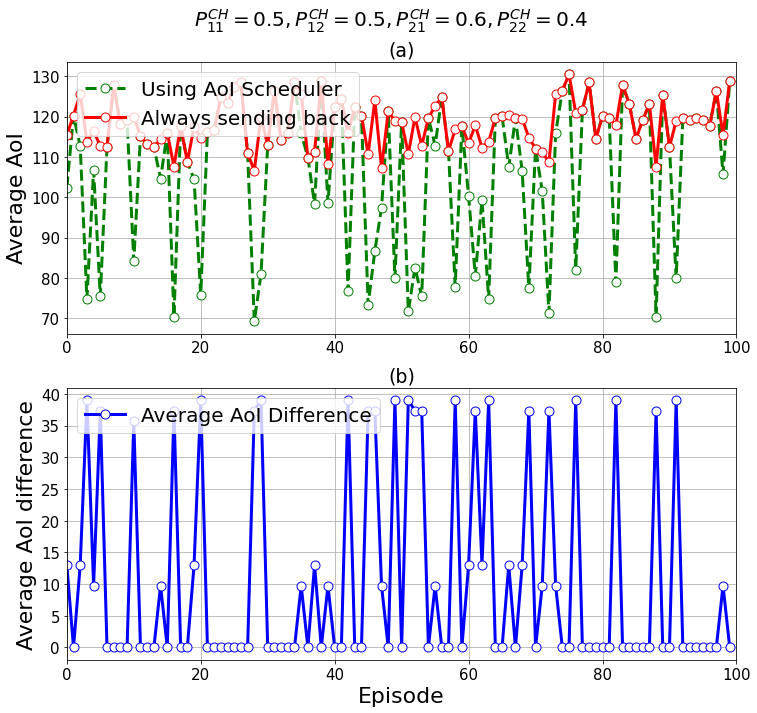

In [5]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from matplotlib import pyplot as plt
from StateDto import State


lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
UseOptimalPolicy = True
episode = 0
NUM_EPISODE = 100
deadline = 40
environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
Total_Reward_List = []
Total_Reward_List_Without_Optimal_Policy = []

for i in range(NUM_EPISODE):
    environment.reset_paramter()
    state , fixed_State = environment.reset_state()
    first_state = state
    print(first_state)
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    episode += 1
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    name = f'({first_state[0]}, {first_state[1]}, {first_state[2]}, {first_state[3]}, {first_state[4]})'

    while not done:
        action = 1
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        if environment.state.U > 0:
          action = 0
          
        state, reward, done = environment.step(action)
        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List_Without_Optimal_Policy.append(sum(Episode_AoI)/deadline)
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    environment.reset_paramter()
    environment.state = State(name, int(first_state[0]), (first_state[1]), int(first_state[2]), int(first_state[3]), int(first_state[4]))
    while not done:
        if UseOptimalPolicy:
          action  = 0 if Optimal_Policy_Dict[name] == 'wait' else 1 
          # print(Optimal_Policy_Dict[name])
        # else:
        #   action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        # if environment.state.Ra == 0 and environment.state.U == 24:
        #   action = 1
        if environment.state.U > 0:
          action = 0
        if environment.sendbackaction == True:
          action = 1
        state, reward, done = environment.step(action)

        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List.append(sum(Episode_AoI)/deadline)


fig, ax = plt.subplots(2,figsize=(12,11))


AVerageAoIUsingScheduler = [sum(Total_Reward_List)/NUM_EPISODE for i in range(NUM_EPISODE)]
AVerageAoIWithoutScheduler = [sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE for i in range(NUM_EPISODE)]

AoI_Difference_List = [Total_Reward_List_Without_Optimal_Policy[i] - Total_Reward_List[i] for i in range(len(Total_Reward_List_Without_Optimal_Policy)) ]

ax[1].plot(AoI_Difference_List, label ='Average AoI Difference', color = "b" ,mec = 'b', mfc = 'w', marker='.', markersize = 18, linestyle = "solid", linewidth = 3)

ax[0].plot(Total_Reward_List, label ='Using AoI Scheduler', color = "g" ,mec = 'g', mfc = 'w', marker='.', markersize = 18, linestyle = "dashed", linewidth = 3)
ax[0].plot(Total_Reward_List_Without_Optimal_Policy, label ='Always sending back' , mec = 'r', mfc = 'w', color = "r", marker='.', markersize = 18,  linestyle = "solid", linewidth = 3)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] == 0:
#         color = 'black'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Send decision', color=color, marker='o', markersize=5)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] != 0:
#         color = 'yellow'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Wait decision', color=color, marker='o', markersize=5)


# ax.plot(AVerageAoIUsingScheduler, label ='Average AoI of 100 Episodes Using AoI Scheduler', color = "g" , markersize = 5, linestyle = "dashed", linewidth = 3)
# ax.plot(AVerageAoIWithoutScheduler, label ='Average AoI of 100 Episodes without AoI Scheduler' , color = "r", markersize = 5,  linestyle = "dashed", linewidth = 3)

ax[0].legend(fontsize = 20, loc='upper left')
ax[1].legend(fontsize = 20, loc='upper left')
handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax[1].legend(by_label.values(), by_label.keys(), loc='upper left')

ax[0].grid()
ax[1].grid()
ax[0].set_ylabel("Average AoI", fontsize = 22.0)
ax[0].set_xlim(xmin=0, xmax=100)
ax[1].set_xlabel("Episode", fontsize = 22.0)
ax[1].set_ylabel("Average AoI difference", fontsize = 22.0)
ax[1].set_xlim(xmin=0, xmax=100)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
string = "$P^{CH}_{11}$$ = 0.5, $$P^{CH}_{12}$$ = 0.5, $$P^{CH}_{21}$$ = 0.6, $$P^{CH}_{22}$$ = 0.4$"
fig.suptitle(string, fontweight ="bold" , y = 0.95, fontsize = 20) 
ax[0].set_title('(a)' , fontsize = 19)
ax[1].set_title('(b)', fontsize = 19)
fig.savefig('SimulationResult_DDDQN_70_125_0.5_0.5.pdf')  

print(f"Average AoI of each episode with AoI scheduler: {sum(Total_Reward_List)/NUM_EPISODE}")
print(f"Average AoI of each episode when DT always send DT data back at request arrival: {sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE}")
print(f"Average AoI diiference: {sum(AoI_Difference_List)/NUM_EPISODE}")

number_of_optimal_actions = 0
for i in AoI_Difference_List:
  if i > 0 or i < 0:
      number_of_optimal_actions += 1 
print(f"Accuracy is {(number_of_optimal_actions/len(AoI_Difference_List))*100}")


In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6quk9nlc
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6quk9nlc
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=18a4bc0ef51d1bb689e4ada74554f25c329c21c2904d8e379fd707cc2bfc02de
  Stored in directory: /tmp/pip-ephem-wheel-cache-nlyq_c0t/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin


created output directory at /content/src
Out bin /content/result.out
